#### <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:150%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > TABLE OF CONTENTS<br><div>  
* [IMPORTS](#1)
* [INTRODUCTION](#2)
    * [CONFIGURATION](#2.1)
    * [CONFIGURATION PARAMETERS](#2.2)    
    * [DATASET COLUMNS](#2.3)
* [PREPROCESSING](#3)
* [ADVERSARIAL CV](#4)
* [EDA AND VISUALS](#5) 
* [DATA TRANSFORMS](#6)
* [MODEL TRAINING](#7)      
* [PLANNED WAY FORWARD](#8)     

<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > IMPORTS<br> <div> 

In [1]:
%%time 

# Installing select libraries:-
from gc import collect;
from warnings import filterwarnings;
filterwarnings('ignore');
from IPython.display import display_html, clear_output;

!pip install -q "/kaggle/input/pythonlibrarieswheelfiles/catboost-1.2.2-cp310-cp310-manylinux2014_x86_64.whl";
!pip install -q "/kaggle/input/pythonlibrarieswheelfiles/lightgbm-4.2.0-py3-none-manylinux_2_28_x86_64.whl";
!pip install -q "/kaggle/input/pythonlibrarieswheelfiles/pandas-2.1.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl";
!pip install -q "/kaggle/input/pythonlibrarieswheelfiles/scikit_learn-1.4.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl";
!pip install -q "/kaggle/input/pythonlibrarieswheelfiles/xgboost-2.0.2-py3-none-manylinux2014_x86_64.whl";
clear_output();

import xgboost as xgb, lightgbm as lgb, catboost as cb, sklearn as sk, pandas as pd;
print(f"---> XGBoost = {xgb.__version__} | LightGBM = {lgb.__version__} | Catboost = {cb.__version__}");
print(f"---> Sklearn = {sk.__version__}| Pandas = {pd.__version__}\n\n");
collect();

---> XGBoost = 2.0.2 | LightGBM = 4.2.0 | Catboost = 1.2.2
---> Sklearn = 1.4.0| Pandas = 2.1.4


CPU times: user 5.97 s, sys: 1.14 s, total: 7.11 s
Wall time: 3min 23s


In [2]:
%%time

# General library imports:-
from copy import deepcopy;
import pandas as pd;
import numpy as np;
import re;
from scipy.stats import mode, kstest, normaltest, shapiro, anderson, jarque_bera;
from collections import Counter;
from itertools import product;
from colorama import Fore, Style, init;
from warnings import filterwarnings;
filterwarnings('ignore');
import joblib;
import os;

from tqdm.notebook import tqdm;
import seaborn as sns;
import matplotlib.pyplot as plt;
from matplotlib.colors import ListedColormap as LCM;
%matplotlib inline

from pprint import pprint;
from functools import partial;

print();
collect();
clear_output();

CPU times: user 276 ms, sys: 21.2 ms, total: 297 ms
Wall time: 378 ms


In [3]:
%%time 

# Importing model and pipeline specifics:-
from category_encoders import OrdinalEncoder, OneHotEncoder;

# Pipeline specifics:-
from sklearn.preprocessing import (RobustScaler, 
                                   MinMaxScaler, 
                                   StandardScaler, 
                                   FunctionTransformer as FT,
                                   PowerTransformer,
                                  );
from sklearn.impute import SimpleImputer as SI;
from sklearn.model_selection import (RepeatedStratifiedKFold as RSKF, 
                                     StratifiedKFold as SKF,
                                     KFold, 
                                     RepeatedKFold as RKF, 
                                     cross_val_score, cross_val_predict
                                    );
from sklearn.inspection import permutation_importance;
from sklearn.feature_selection import mutual_info_classif, RFE;
from sklearn.pipeline import Pipeline, make_pipeline;
from sklearn.base import BaseEstimator, TransformerMixin;
from sklearn.compose import ColumnTransformer;

# ML Model training:-
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer;
from xgboost import DMatrix, XGBClassifier as XGBC;
from lightgbm import log_evaluation, early_stopping, LGBMClassifier as LGBMC;
from catboost import CatBoostClassifier as CBC, Pool;

# Ensemble and tuning:-
import optuna;
from optuna import Trial, trial, create_study;
from optuna.pruners import HyperbandPruner;
from optuna.samplers import TPESampler, CmaEsSampler;
optuna.logging.set_verbosity = optuna.logging.ERROR;

clear_output();
print();
collect();


CPU times: user 1.67 s, sys: 110 ms, total: 1.78 s
Wall time: 2.12 s


In [4]:
%%time 

# Setting rc parameters in seaborn for plots and graphs- 
# Reference - https://matplotlib.org/stable/tutorials/introductory/customizing.html:-
# To alter this, refer to matplotlib.rcParams.keys()

sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.75,  
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : '#0099e6',
         'axes.titlesize'       : 8.5,
         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,        
        });

# Color printing    
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    "Prints color outputs using colorama using a text F-string";
    print(style + color + text + Style.RESET_ALL); 

# Making sklearn pipeline outputs as dataframe:-
from sklearn import set_config; 
set_config(transform_output = "pandas");
pd.set_option('display.max_columns', 50);
pd.set_option('display.max_rows', 50);

print();
collect();



CPU times: user 137 ms, sys: 280 µs, total: 138 ms
Wall time: 137 ms


<a id="2"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > INTRODUCTION<br><div> 

| Version<br>Number | Version Details | CV score| Single/ Ensemble|Public LB Score|
| :-: | --- | :-: | :-: |:-:|
| **V1** |* BMI Risk factor addition <br> * Relevant column encoding with Ordinal encoding and OHE <br> * 5 x1 RSKF CV Boosted tree models <br> * Optuna ensemble <br> * No pseudo labels|0.90645|Ensemble <br> Optuna|0.90426|
| **V2** |* BMI Risk factor addition and excluded secondary features <br> * Relevant column encoding with Ordinal encoding and OHE <br> * 10 x1 RSKF CV Boosted tree models <br> * Optuna ensemble <br> * No pseudo labels|0.90747|Ensemble <br> Optuna||
| **V3** |* Better secondary features from public work <br> * Relevant column encoding with Ordinal encoding and OHE <br> * 10 x1 RSKF CV Boosted tree models <br> * Optuna ensemble <br> * No pseudo labels <br> * Hard voting blend with public work|0.90631|Ensemble <br> Optuna|0.91726|
| **V4** |* Same as V3 <br> * Updated public data to blend|0.90631|Ensemble <br> Optuna||

<a id="2.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > CONFIGURATION<br><div> 

In [5]:
%%time

# Configuration class:-
class CFG:
    """
    Configuration class for parameters and CV strategy for tuning and training
    Some parameters may be unused here as this is a general configuration class
    """;
    
    # Data preparation:-   
    version_nb         = 4;
    test_req           = "N";
    test_sample_frac   = 0.025;
    gpu_switch         = "OFF"; 
    state              = 42;
    target             = 'NObeyesdad';
    episode            = 2;
    season             = 4;
    path               = f"/kaggle/input/playground-series-s{season}e{episode}";
    orig_path          = f"/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv";
    public_subs_path   = f"/kaggle/input/playgrounds4e02ancillary/S4E02Ancillary_V3.csv";
    
    dtl_preproc_req    = "Y";
    adv_cv_req         = "N";
    ftre_plots_req     = 'Y';
    ftre_imp_req       = "Y";
    
    # Data transforms and scaling:-    
    conjoin_orig_data  = "Y";
    drop_nulls         = "N";
    sec_ftre_req       = "Y";
    scale_req          = "N";
    # NOTE---Keep a value here even if scale_req = N, this is used for linear models:-
    scl_method         = "Z"; 
    enc_method         = 'Label';
    OH_cols            = ["MTRANS"];
    tgt_mapper         = {'Insufficient_Weight'  : 0,
                          'Normal_Weight'        : 1,
                          'Overweight_Level_I'   : 2,
                          'Overweight_Level_II'  : 3,
                          'Obesity_Type_I'       : 4,
                          'Obesity_Type_II'      : 5,
                          'Obesity_Type_III'     : 6,    
                         };

    # Model Training:- 
    baseline_req       = "N";
    pstprcs_oof        = "N";
    pstprcs_train      = "N";
    pstprcs_test       = "N";
    ML                 = "Y";
    
    pseudo_lbl_req     = "N";
    pseudolbl_up       = 0.975;
    pseudolbl_low      = 0.00;
    
    use_orig_allfolds  = "N";
    n_splits           = 3 if test_req == "Y" else 10;
    n_repeats          = 1 ;
    nbrnd_erly_stp     = 75;
    mdlcv_mthd         = 'RSKF';
    
    # Ensemble:-    
    ensemble_req       = "Y";
    hill_climb_req     = "N";
    optuna_req         = "Y";
    LAD_req            = "N";
    enscv_mthd         = "RSKF";
    metric_obj         = 'maximize';
    ntrials            = 10 if test_req == "Y" else 150;
    
    # Global variables for plotting:-
    grid_specs = {'visible': True, 'which': 'both', 'linestyle': '--', 
                           'color': 'lightgrey', 'linewidth': 0.75};
    title_specs = {'fontsize': 9, 'fontweight': 'bold', 'color': 'tab:blue'};

print();
PrintColor(f"--> Configuration done!\n");
collect();


--> Configuration done!

CPU times: user 137 ms, sys: 191 µs, total: 137 ms
Wall time: 136 ms


In [6]:
%%time 

# Defining functions to be used throughout the code for common tasks:-

# Scaler to be used for continuous columns:- 
all_scalers = {'Robust': RobustScaler(), 
               'Z': StandardScaler(), 
               'MinMax': MinMaxScaler(),
               "PT" : PowerTransformer(),
              };
scaler      = all_scalers.get(CFG.scl_method);

# Making a directory to store the model objects:-
if os.path.exists("/kaggle/working/MLModels") == True:
    PrintColor(f"\n---> MLModels already exists\n", color = Fore.RED);
else:
    os.mkdir("MLModels");
    PrintColor(f"\n---> Made directory MLModels to store models for inference\n", color = Fore.RED)


collect();
print();



---> Made directory MLModels to store models for inference


CPU times: user 133 ms, sys: 0 ns, total: 133 ms
Wall time: 133 ms


<a id="2.2"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > CONFIGURATION PARAMETERS<br><div> 


| Parameter         | Description                                             | Possible value choices|
| ---               | ---                                                     | :-:                   |
|  version_nb       | Version Number                                          | integer               |
|  test_req         | Are we testing syntax here?                             | Y/N                   |  
|  test_sample_frac | Sample size for syntax test                             | float(0-1)/ int       |     
|  gpu_switch       | GPU switch                                              | ON/OFF                |
|  state            | Random state for most purposes                          | integer               |
|  target           | Target column name                                      | yield                 |
|  episode          | Episode Number                                          | integer               |
|  season           | Season Number                                           | integer               |    
|  path             | Path for input data files                               |                       |
|  orig_path        | Path for input original data files                      |                       |
|  dtl_preproc_req  | Proprocessing required                                  | Y/N                   |    
|  adv_cv_req       | Adversarial CV required                                 | Y/N                   |
|  ftre_plots_req   | Feature plots required                                  | Y/N                   |
|  ftre_imp_req     | Feature importance required                             | Y/N                   |
|  conjoin_orig_data| Conjoin original data                                   | Y/N                   |
|  drop_nulls       | Drop original data nulls                                | Y/N                   |    
|  sec_ftre_req     | Secondary features required                             | Y/N                   |
|  scale_req        | Scaling required                                        | Y/N                   |
|  scl_method       | Scaling method                                          | Z/ Robust/ MinMax     |
|  enc_method       | Encoding method                                         |-                      |
|  OH_cols          | Onehot columns                                          |list                   |
|  tgt_mapper       | Target categories                                       |dict                   |   
|  baseline_req     | Baseline model required                                 | Y/N                   |
|  pstprcs_oof      | Post-process OOF after model training                   | Y/N                   |
|  pstprcs_train    | Post-process OOF during model training for dev-set      | Y/N                   |
|  pstprcs_test     | Post-process test after training                        | Y/N                   |
|  ML               | Machine Learning Models                                 | Y/N                   |
|  use_orig_all_folds| Use original data in all folds                         | Y/N                   |
|  n_splits         | Number of CV splits                                     | integer               |
|  n_repeats        | Number of CV repeats                                    | integer               |
|  nbrnd_erly_stp   | Number of early stopping rounds                         | integer               |
|  mdl_cv_mthd      | Model CV method name                                    | RKF/ RSKF/ SKF/ KFold |

<a id="2.3"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > DATASET AND COMPETITION DETAILS<br><div>
    
**Data columns**<br>
This is available in the original data description as below<br>
https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster <br>
<br>**Competition details and notebook objectives**<br>
1. This is a multi-class classification challenge to predict obesity risk. **Accuracy score** is the metric for the challenge<br>
2. In this starter notebook, we start the assignment with a detailed EDA, feature plots, interaction effects, adversarial CV analysis and develop starter models to initiate the challenge. We will also incorporate other opinions and approaches as we move along the challenge.<br>
<br>
**Model strategy** <br>
We start off with simple tree based ML models and a mean ensemble to create sample inputs for the submission. <br>


<a id="3"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > PREPROCESSING<br><div> 

In [7]:
%time 

class Preprocessor():
    """
    This class aims to do the below-
    1. Read the datasets
    2. In this case, process the original data
    3. Check information and description
    4. Check unique values and nulls
    5. Collate starting features 
    6. Conjoin train-original data if requested based on Adversarial CV results
    """;
    
    def __init__(self):
        self.train             = pd.read_csv(os.path.join(CFG.path,"train.csv"), index_col = 'id');
        self.test              = pd.read_csv(os.path.join(CFG.path ,"test.csv"), index_col = 'id');
        self.target            = CFG.target ;
        self.original          = pd.read_csv(CFG.orig_path);
        self.conjoin_orig_data = CFG.conjoin_orig_data;
        self.dtl_preproc_req   = CFG.dtl_preproc_req;
        self.test_req          = CFG.test_req;
        
        self.sub_fl   = pd.read_csv(os.path.join(CFG.path, "sample_submission.csv"));
        PrintColor(f"Data shapes - train-test-original | {self.train.shape} {self.test.shape} {self.original.shape}");
        
        for tbl in [self.train, self.original, self.test]:
            tbl.columns = tbl.columns.str.replace(r"\(|\)|\s+","", regex = True);
            
        PrintColor(f"\nTrain set head", color = Fore.CYAN);
        display(self.train.head(5).style.format(precision = 3));
        PrintColor(f"\nTest set head", color = Fore.CYAN);
        display(self.test.head(5).style.format(precision = 3));
        PrintColor(f"\nOriginal set head", color = Fore.CYAN);
        display(self.original.head(5).style.format(precision = 3));
                 
        # Resetting original data index:-
        self.original.index = range(len(self.original));
        self.original.index+= max(self.test.index) + 1;
        self.original.index.name = 'id';
        
        #  Changing original data column order to match the competition column structure:-
        self.original = self.original.reindex(self.train.columns, axis=1);
              
    def _AddSourceCol(self):
        self.train['Source']    = "Competition";
        self.test['Source']     = "Competition";
        self.original['Source'] = 'Original';
        
        self.strt_ftre = self.test.columns;
        return self;
          
    def _CollateInfoDesc(self):
        if self.dtl_preproc_req == "Y":
            PrintColor(f"\n{'-'*20} Information and description {'-'*20}\n", color = Fore.MAGENTA);

            # Creating dataset information and description:
            for lbl, df in {'Train': self.train, 'Test': self.test, 'Original': self.original}.items():
                PrintColor(f"\n{lbl} description\n");
                display(df.describe(percentiles= [0.05, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]).\
                        transpose().\
                        drop(columns = ['count'], errors = 'ignore').\
                        drop([CFG.target], axis=0, errors = 'ignore').\
                        style.format(formatter = '{:,.2f}').\
                        background_gradient(cmap = 'Blues')
                       );

                PrintColor(f"\n{lbl} information\n");
                display(df.info());
                collect();
        return self;
    
    def _CollateUnqNull(self):
        
        if self.dtl_preproc_req == "Y":
            # Dislaying the unique values across train-test-original:-
            PrintColor(f"\nUnique and null values\n");
            _ = pd.concat([self.train[self.strt_ftre].nunique(), 
                           self.test[self.strt_ftre].nunique(), 
                           self.original[self.strt_ftre].nunique(),
                           self.train[self.strt_ftre].isna().sum(axis=0),
                           self.test[self.strt_ftre].isna().sum(axis=0),
                           self.original[self.strt_ftre].isna().sum(axis=0)
                          ], 
                          axis=1);
            _.columns = ['Train_Nunq', 'Test_Nunq', 'Original_Nunq', 
                         'Train_Nulls', 'Test_Nulls', 'Original_Nulls'
                        ];

            display(_.T.style.background_gradient(cmap = 'Blues', axis=1).\
                    format(formatter = '{:,.0f}')
                   );
            
        return self;
       
    def DoPreprocessing(self):
        self._AddSourceCol();
        self._CollateInfoDesc();
        self._CollateUnqNull();
        
        return self; 
        
    def ConjoinTrainOrig(self):
        if self.conjoin_orig_data == "Y":
            PrintColor(f"Train shape before conjoining with original = {self.train.shape}");
            train = pd.concat([self.train, self.original], axis=0, ignore_index = True);
            PrintColor(f"Train shape after conjoining with original= {train.shape}");
            
            train = train.drop_duplicates();
            PrintColor(f"Train shape after de-duping = {train.shape}");
            
            train.index = range(len(train));
            train.index.name = 'id';
        
        else:
            PrintColor(f"We are using the competition training data only");
            train = self.train;
        return train;
          
collect();
print();

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs



In [8]:
%%time 

pp = Preprocessor();
pp.DoPreprocessing();

print();
collect();

Data shapes - train-test-original | (20758, 17) (13840, 16) (2111, 17)

Train set head


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24.443,1.700,81.670,yes,yes,2.000,2.983,Sometimes,no,2.764,no,0.000,0.976,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000,1.560,57.000,yes,yes,2.000,3.000,Frequently,no,2.000,no,1.000,1.000,no,Automobile,Normal_Weight
2,Female,18.000,1.711,50.166,yes,yes,1.881,1.412,Sometimes,no,1.910,no,0.866,1.674,no,Public_Transportation,Insufficient_Weight
3,Female,20.953,1.711,131.275,yes,yes,3.000,3.000,Sometimes,no,1.674,no,1.468,0.780,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641,1.914,93.798,yes,yes,2.680,1.971,Sometimes,no,1.980,no,1.968,0.932,Sometimes,Public_Transportation,Overweight_Level_II



Test set head


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
id,,,,,,,,,,,,,,,,
20758,Male,26.900,1.848,120.644,yes,yes,2.939,3.000,Sometimes,no,2.826,no,0.855,0.000,Sometimes,Public_Transportation
20759,Female,21.000,1.600,66.000,yes,yes,2.000,1.000,Sometimes,no,3.000,no,1.000,0.000,Sometimes,Public_Transportation
20760,Female,26.000,1.643,111.601,yes,yes,3.000,3.000,Sometimes,no,2.622,no,0.000,0.251,Sometimes,Public_Transportation
20761,Male,20.979,1.553,103.669,yes,yes,2.000,2.978,Sometimes,no,2.786,no,0.095,0.000,Sometimes,Public_Transportation
20762,Female,26.000,1.627,104.835,yes,yes,3.000,3.000,Sometimes,no,2.654,no,0.000,0.741,Sometimes,Public_Transportation



Original set head


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000,1.620,64.000,yes,no,2.000,3.000,Sometimes,no,2.000,no,0.000,1.000,no,Public_Transportation,Normal_Weight
1,Female,21.000,1.520,56.000,yes,no,3.000,3.000,Sometimes,yes,3.000,yes,3.000,0.000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000,1.800,77.000,yes,no,2.000,3.000,Sometimes,no,2.000,no,2.000,1.000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000,1.800,87.000,no,no,3.000,3.000,Sometimes,no,2.000,no,2.000,0.000,Frequently,Walking,Overweight_Level_I
4,Male,22.000,1.780,89.800,no,no,2.000,1.000,Sometimes,no,2.000,no,0.000,0.000,Sometimes,Public_Transportation,Overweight_Level_II



-------------------- Information and description --------------------


Train description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
Age,23.84,5.69,14.00,17.99,20.00,22.82,26.00,31.39,35.46,41.00,61.00
Height,1.70,0.09,1.45,1.56,1.63,1.70,1.76,1.82,1.85,1.89,1.98
Weight,87.89,26.38,39.00,49.00,66.00,84.06,111.60,121.00,132.12,137.86,165.06
FCVC,2.45,0.53,1.00,1.83,2.00,2.39,3.00,3.00,3.00,3.00,3.00
NCP,2.76,0.71,1.00,1.00,3.00,3.00,3.00,3.00,3.52,4.00,4.00
CH2O,2.03,0.61,1.00,1.00,1.79,2.00,2.55,2.87,3.00,3.00,3.00
FAF,0.98,0.84,0.00,0.00,0.01,1.00,1.59,2.00,2.55,3.00,3.00
TUE,0.62,0.60,0.00,0.00,0.00,0.57,1.00,1.44,2.00,2.00,2.00



Train information

<class 'pandas.core.frame.DataFrame'>
Index: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF              

None


Test description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
Age,23.95,5.80,14.00,18.00,20.00,22.91,26.00,31.74,37.06,41.68,61.00
Height,1.70,0.09,1.45,1.55,1.63,1.70,1.76,1.82,1.85,1.90,1.98
Weight,87.38,26.11,39.00,49.00,65.00,83.95,111.16,120.90,131.34,137.79,165.06
FCVC,2.44,0.53,1.00,1.85,2.00,2.36,3.00,3.00,3.00,3.00,3.00
NCP,2.75,0.71,1.00,1.00,3.00,3.00,3.00,3.00,3.39,4.00,4.00
CH2O,2.03,0.61,1.00,1.00,1.77,2.00,2.55,2.89,3.00,3.00,3.00
FAF,0.97,0.84,0.00,0.00,0.00,1.00,1.57,2.00,2.60,3.00,3.00
TUE,0.61,0.61,0.00,0.00,0.00,0.55,1.00,1.49,2.00,2.00,2.00



Test information

<class 'pandas.core.frame.DataFrame'>
Index: 13840 entries, 20758 to 34597
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          13840 non-null  object 
 1   Age                             13840 non-null  float64
 2   Height                          13840 non-null  float64
 3   Weight                          13840 non-null  float64
 4   family_history_with_overweight  13840 non-null  object 
 5   FAVC                            13840 non-null  object 
 6   FCVC                            13840 non-null  float64
 7   NCP                             13840 non-null  float64
 8   CAEC                            13840 non-null  object 
 9   SMOKE                           13840 non-null  object 
 10  CH2O                            13840 non-null  float64
 11  SCC                             13840 non-null  object 
 12  FAF           

None


Original description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
Age,24.31,6.35,14.00,17.89,19.95,22.78,26.00,33.23,38.10,43.58,61.00
Height,1.70,0.09,1.45,1.55,1.63,1.70,1.77,1.82,1.85,1.91,1.98
Weight,86.59,26.19,39.00,48.50,65.47,83.00,107.43,120.92,131.92,150.33,173.00
FCVC,2.42,0.53,1.00,1.52,2.00,2.39,3.00,3.00,3.00,3.00,3.00
NCP,2.69,0.78,1.00,1.00,2.66,3.00,3.00,3.11,3.75,4.00,4.00
CH2O,2.01,0.61,1.00,1.00,1.58,2.00,2.48,2.90,3.00,3.00,3.00
FAF,1.01,0.85,0.00,0.00,0.12,1.00,1.67,2.00,2.68,3.00,3.00
TUE,0.66,0.61,0.00,0.00,0.00,0.63,1.00,1.60,2.00,2.00,2.00



Original information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 34598 to 36708
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF   

None


Unique and null values



,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Source
Train_Nunq,2,"1,703","1,833","1,979",2,2,934,689,4,2,"1,506",2,"1,360","1,297",3,5,1
Test_Nunq,2,"1,539","1,739","1,798",2,2,828,649,4,2,"1,366",2,"1,260","1,172",4,5,1
Original_Nunq,2,"1,402","1,574","1,525",2,2,810,635,4,2,"1,268",2,"1,190","1,129",4,5,1
Train_Nulls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Test_Nulls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Original_Nulls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



CPU times: user 1.11 s, sys: 39.5 ms, total: 1.14 s
Wall time: 1.2 s


## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > INFERENCES<br> <div>

<div style= "font-family: Cambria; letter-spacing: 0px; color:#000000; font-size:110%; text-align:left;padding:3.0px; background: #f2f2f2" >
1. We have numerical columns and object columns that necessitate encoding<br>
2. The dataset is quite small, so building a CV is difficult- luck will play a huge part in this challenge<br>
</div>

<a id="4"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > ADVERSARIAL CV<br><div>

In [9]:
%%time

# Performing adversarial CV between the 2 specified datasets:-
def Do_AdvCV(df1:pd.DataFrame, df2:pd.DataFrame, source1:str, source2:str):
    "This function performs an adversarial CV between the 2 provided datasets if needed by the user";
    
    # Adversarial CV per column:-
    ftre = pp.test.select_dtypes(include = np.number).\
    drop(columns = ['id', "Source"], errors = 'ignore').columns;
    adv_cv = {};

    for col in ftre:
        shuffle_state = np.random.randint(low = 10, high = 100, size= 1);

        full_df = \
        pd.concat([df1[[col]].assign(Source = source1), df2[[col]].assign(Source = source2)], 
                  axis=0, ignore_index = True).\
        sample(frac = 1.00, random_state = shuffle_state);

        full_df = full_df.assign(Source_Nb = full_df['Source'].eq(source2).astype(np.int8));

        # Checking for adversarial CV:-
        model = LGBMC(random_state = CFG.state, max_depth = 6, learning_rate = 0.05);
        cv    = all_cv['SKF'];
        score = np.mean(cross_val_score(model, 
                                        full_df[[col]], 
                                        full_df.Source_Nb, 
                                        scoring= 'roc_auc', 
                                        cv     = cv)
                       );
        adv_cv.update({col: round(score, 4)});
        collect();
    
    del ftre;
    collect();
    
    fig, ax = plt.subplots(1,1,figsize = (12, 5));
    pd.Series(adv_cv).plot.bar(color = 'tab:blue', ax = ax);
    ax.axhline(y = 0.60, color = 'red', linewidth = 2.75);
    ax.grid(**CFG.grid_specs); 
    plt.yticks(np.arange(0.0, 0.81, 0.05));
    plt.show();
    
# Implementing the adversarial CV:-
if CFG.adv_cv_req == "Y":
    PrintColor(f"\n---------- Adversarial CV - Train vs Original ----------\n", 
               color = Fore.MAGENTA);
    Do_AdvCV(df1 = pp.train, df2 = pp.original, source1 = 'Train', source2 = 'Original');
    
    PrintColor(f"\n---------- Adversarial CV - Train vs Test ----------\n", 
               color = Fore.MAGENTA);
    Do_AdvCV(df1 = pp.train, df2 = pp.test, source1 = 'Train', source2 = 'Test');
    
    PrintColor(f"\n---------- Adversarial CV - Original vs Test ----------\n", 
               color = Fore.MAGENTA);
    Do_AdvCV(df1 = pp.original, df2 = pp.test, source1 = 'Original', source2 = 'Test');   
    
if CFG.adv_cv_req == "N":
    PrintColor(f"\nAdversarial CV is not needed\n", color = Fore.RED);
    
collect();
print();


Adversarial CV is not needed


CPU times: user 134 ms, sys: 0 ns, total: 134 ms
Wall time: 135 ms


In [10]:
%%time 

print();
train, test, strt_ftre = pp.ConjoinTrainOrig(), pp.test.copy(deep = True), deepcopy(pp.strt_ftre);
cat_cols  = ["Gender", "family_history_with_overweight", "FAVC", "CAEC", "SMOKE", "SCC", "CALC", "MTRANS"];
cont_cols = [col for col in pp.strt_ftre if col not in cat_cols + [CFG.target, "Source"]];

if CFG.drop_nulls == "Y":
    train = train.dropna();
else: 
    pass;

PrintColor(f"\nCategory columns\n");
display(cat_cols);
PrintColor(f"\nContinuous columns\n");
display(np.array(cont_cols));
PrintColor(f"\nAll columns\n");
display(strt_ftre);

print();
collect();


Train shape before conjoining with original = (20758, 18)
Train shape after conjoining with original= (22869, 18)
Train shape after de-duping = (22845, 18)

Category columns



['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS']


Continuous columns



array(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'],
      dtype='<U6')


All columns



Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'Source'],
      dtype='object')


CPU times: user 189 ms, sys: 1.52 ms, total: 190 ms
Wall time: 190 ms


<a id="5"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > VISUALS AND EDA <br><div> 
 

<a id="5.2"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > TARGET PLOT<br><div>

Target plot ---> : 0it [00:00, ?it/s]

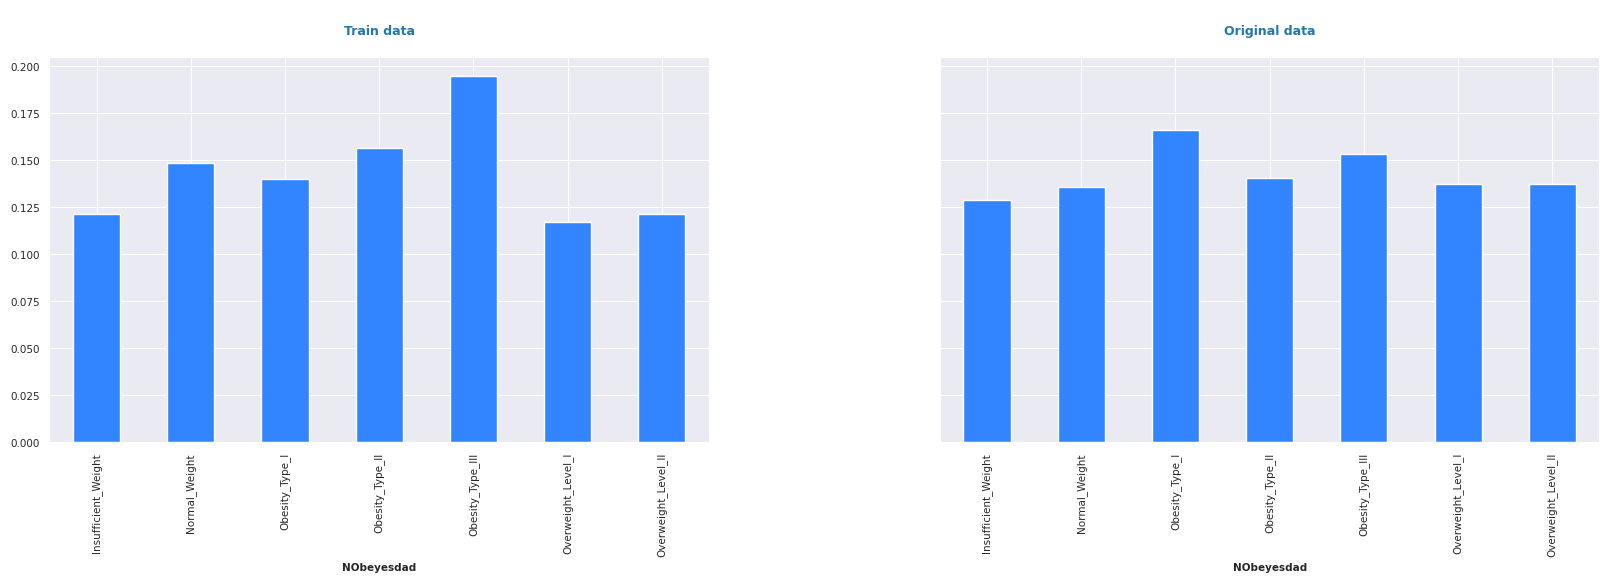


CPU times: user 788 ms, sys: 24.8 ms, total: 812 ms
Wall time: 873 ms


In [11]:
%%time 

if CFG.ftre_plots_req == "Y":
    fig, axes = plt.subplots(1,2, figsize = (20, 5), sharey = True, gridspec_kw = {'wspace': 0.35});
    
    for i, df in tqdm(enumerate([pp.train, pp.original]), "Target plot ---> "):
        ax= axes[i];
        a = df[CFG.target].value_counts(normalize = True);
        a.sort_index().plot.bar(color = '#3385ff', ax = ax);
        df_name = 'Train' if i == 0 else "Original";
        _ = ax.set_title(f"\n{df_name} data\n", **CFG.title_specs);
        
    plt.tight_layout();
    plt.show();
    
print();
collect();

<a id="5.5"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > CONTINUOUS COLUMN PLOTS<br><div>

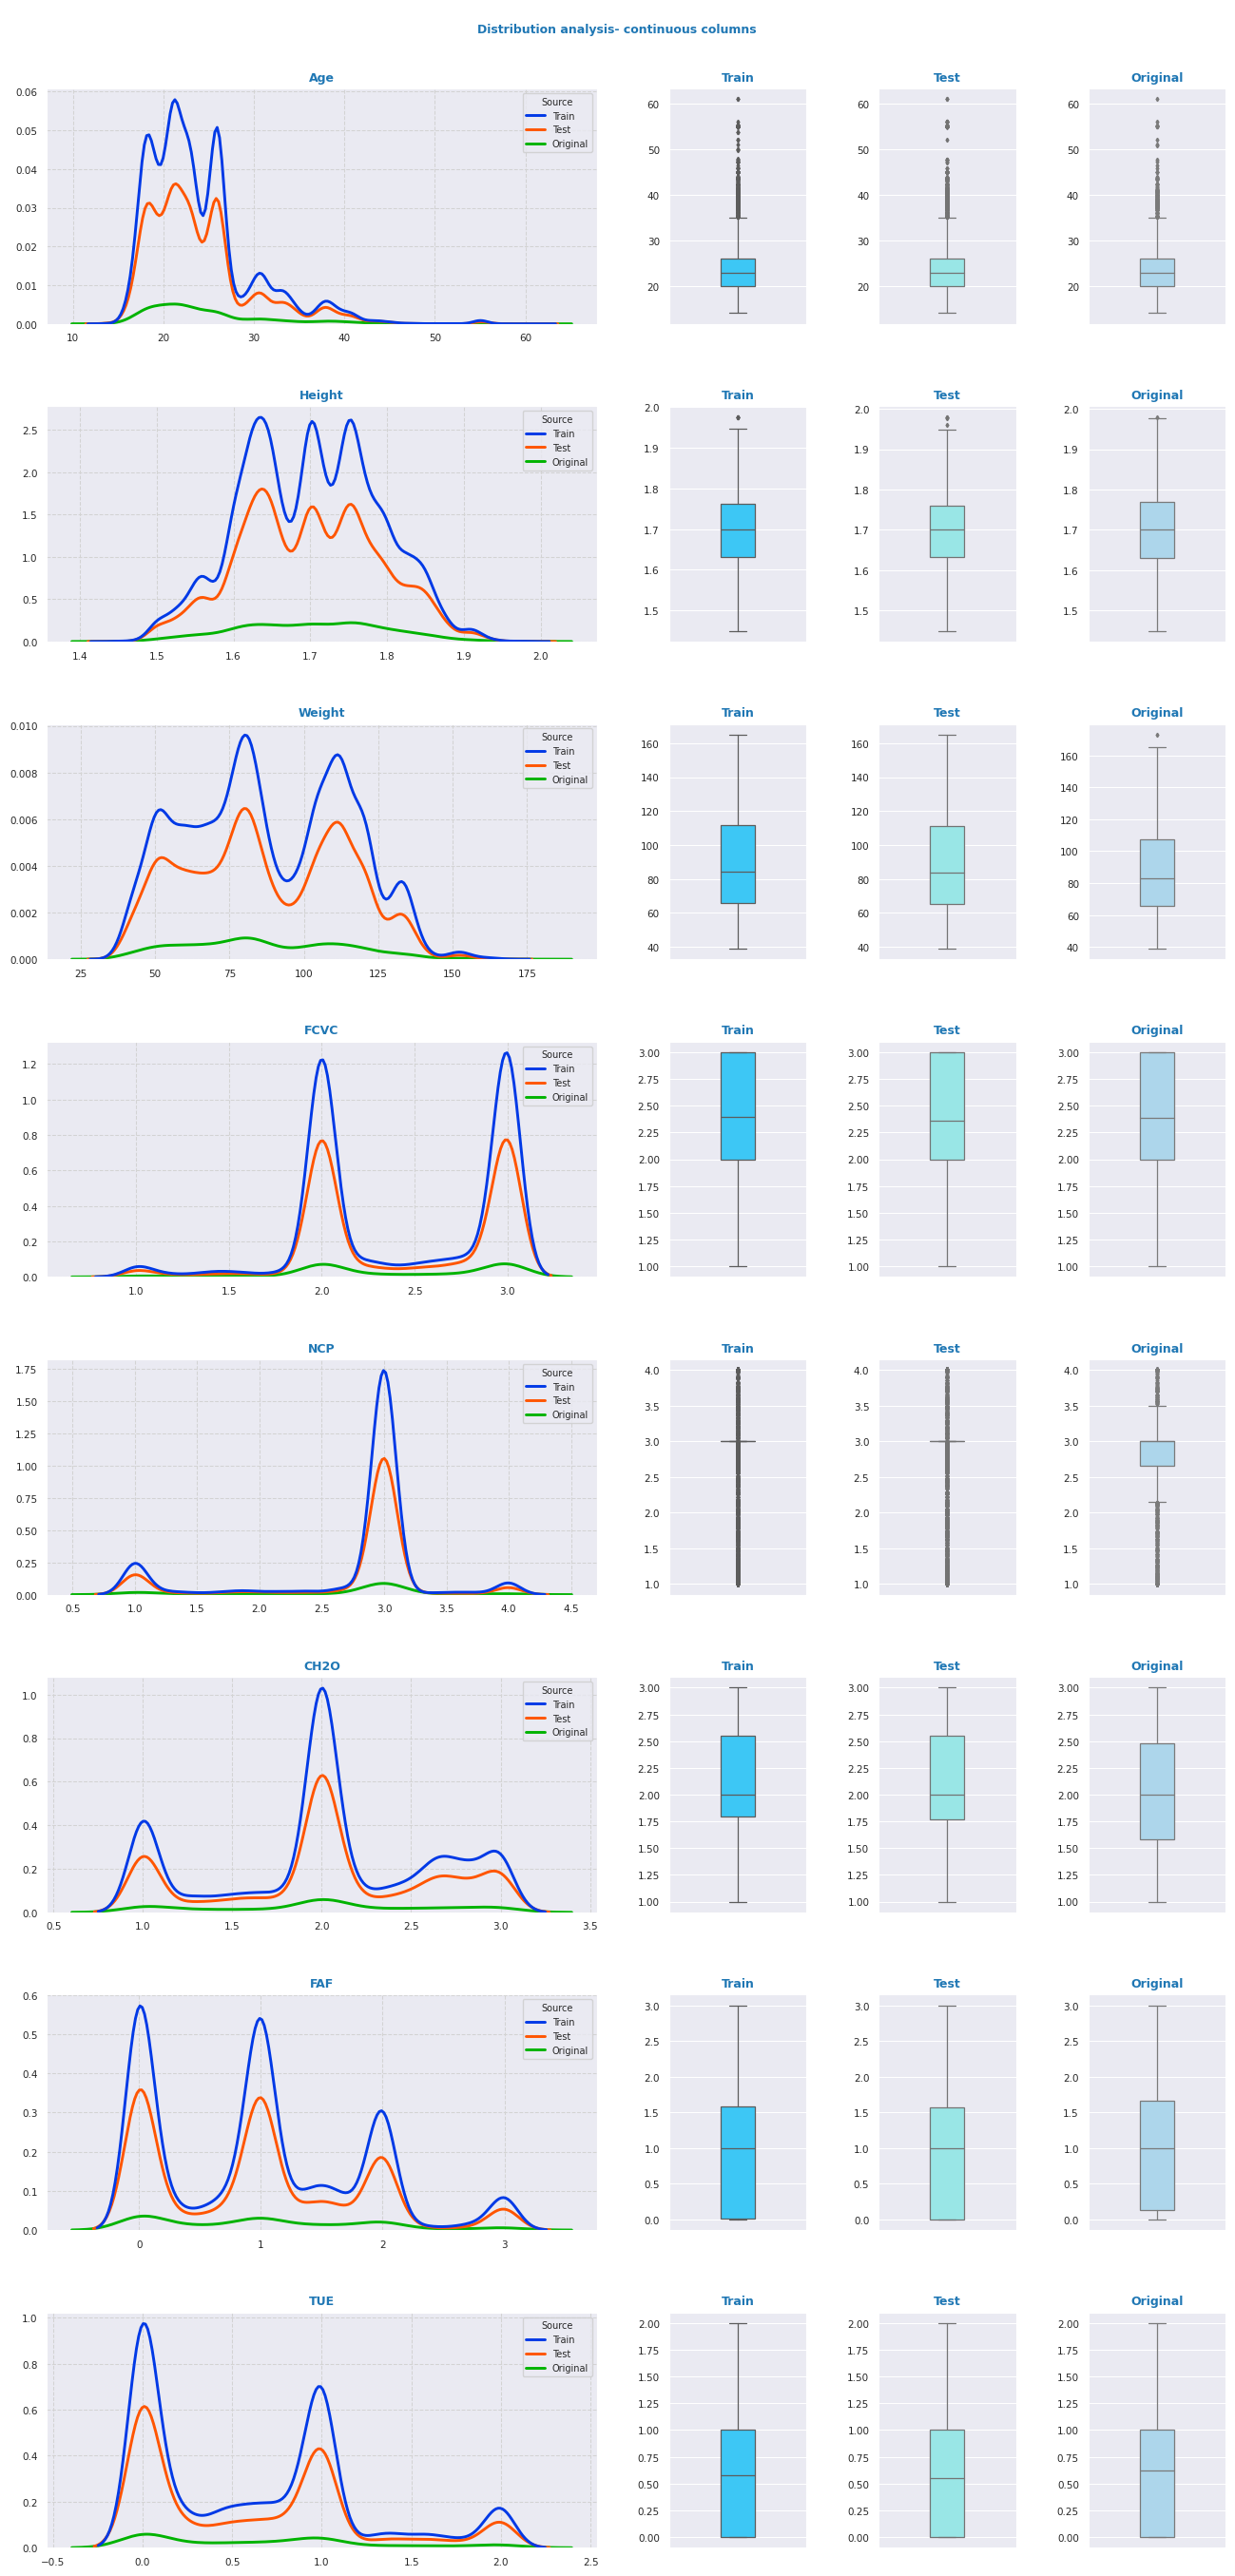


CPU times: user 13.7 s, sys: 5.9 s, total: 19.6 s
Wall time: 10.8 s


In [12]:
%%time 

if CFG.ftre_plots_req == "Y":
    df = pd.concat([pp.train[cont_cols].assign(Source = 'Train'), 
                    pp.test[cont_cols].assign(Source = 'Test'),
                    pp.original[cont_cols].assign(Source = "Original")
                   ], 
                   axis=0, ignore_index = True
                  );
    
    fig, axes = plt.subplots(len(cont_cols), 4 ,figsize = (16, len(cont_cols) * 4.2), 
                             gridspec_kw = {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.80, 0.20, 0.20, 0.20]});
    
    for i,col in enumerate(cont_cols):
        ax = axes[i,0];
        sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', 
                    palette = ['#0039e6', '#ff5500', '#00b300'], 
                    ax = ax, linewidth = 2.1
                   );
        ax.set_title(f"\n{col}", **CFG.title_specs);
        ax.grid(**CFG.grid_specs);
        ax.set(xlabel = '', ylabel = '');
        
        ax = axes[i,1];
        sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25,
                    color = '#33ccff', saturation = 0.90, linewidth = 0.90, 
                    fliersize= 2.25,
                    ax = ax);
        ax.set(xlabel = '', ylabel = '');
        ax.set_title(f"Train", **CFG.title_specs);
        
        ax = axes[i,2];
        sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, fliersize= 2.25,
                    color = '#80ffff', saturation = 0.6, linewidth = 0.90, 
                    ax = ax); 
        ax.set(xlabel = '', ylabel = '');
        ax.set_title(f"Test", **CFG.title_specs);
        
        ax = axes[i,3];
        sns.boxplot(data = df.loc[df.Source == 'Original', [col]], y = col, width = 0.25, fliersize= 2.25,
                    color = '#99ddff', saturation = 0.6, linewidth = 0.90, 
                    ax = ax); 
        ax.set(xlabel = '', ylabel = '');
        ax.set_title(f"Original", **CFG.title_specs);
              
    plt.suptitle(f"\nDistribution analysis- continuous columns\n", **CFG.title_specs, 
                 y = 0.905, x = 0.50
                );
    plt.tight_layout();
    plt.show();
    
print();
collect();

In [13]:
%%time 

# Calculating skewness across columns:-
skew_df = pd.DataFrame(index = cont_cols);
for col, df in {"Train": pp.train[cont_cols], 
                "Test": pp.test[cont_cols], 
                "Original": pp.original[cont_cols]}.items():   
    skew_df = \
    pd.concat([skew_df, 
               df.drop(columns = [CFG.target, "Source", "id"], errors = "ignore").skew()],
               axis=1).rename({0: col}, axis=1);

PrintColor(f"\nSkewness across independent features\n");
display(skew_df.transpose().style.format(precision = 2).background_gradient("Pastel2"));

collect();
print();


Skewness across independent features



,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
Train,1.59,0.02,0.09,-0.36,-1.56,-0.21,0.51,0.67
Test,1.57,0.06,0.09,-0.34,-1.54,-0.20,0.53,0.70
Original,1.53,-0.01,0.26,-0.43,-1.11,-0.10,0.50,0.62



CPU times: user 212 ms, sys: 964 µs, total: 213 ms
Wall time: 212 ms


<a id="5.6"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > CATEGORY COLUMN PLOTS<br><div>

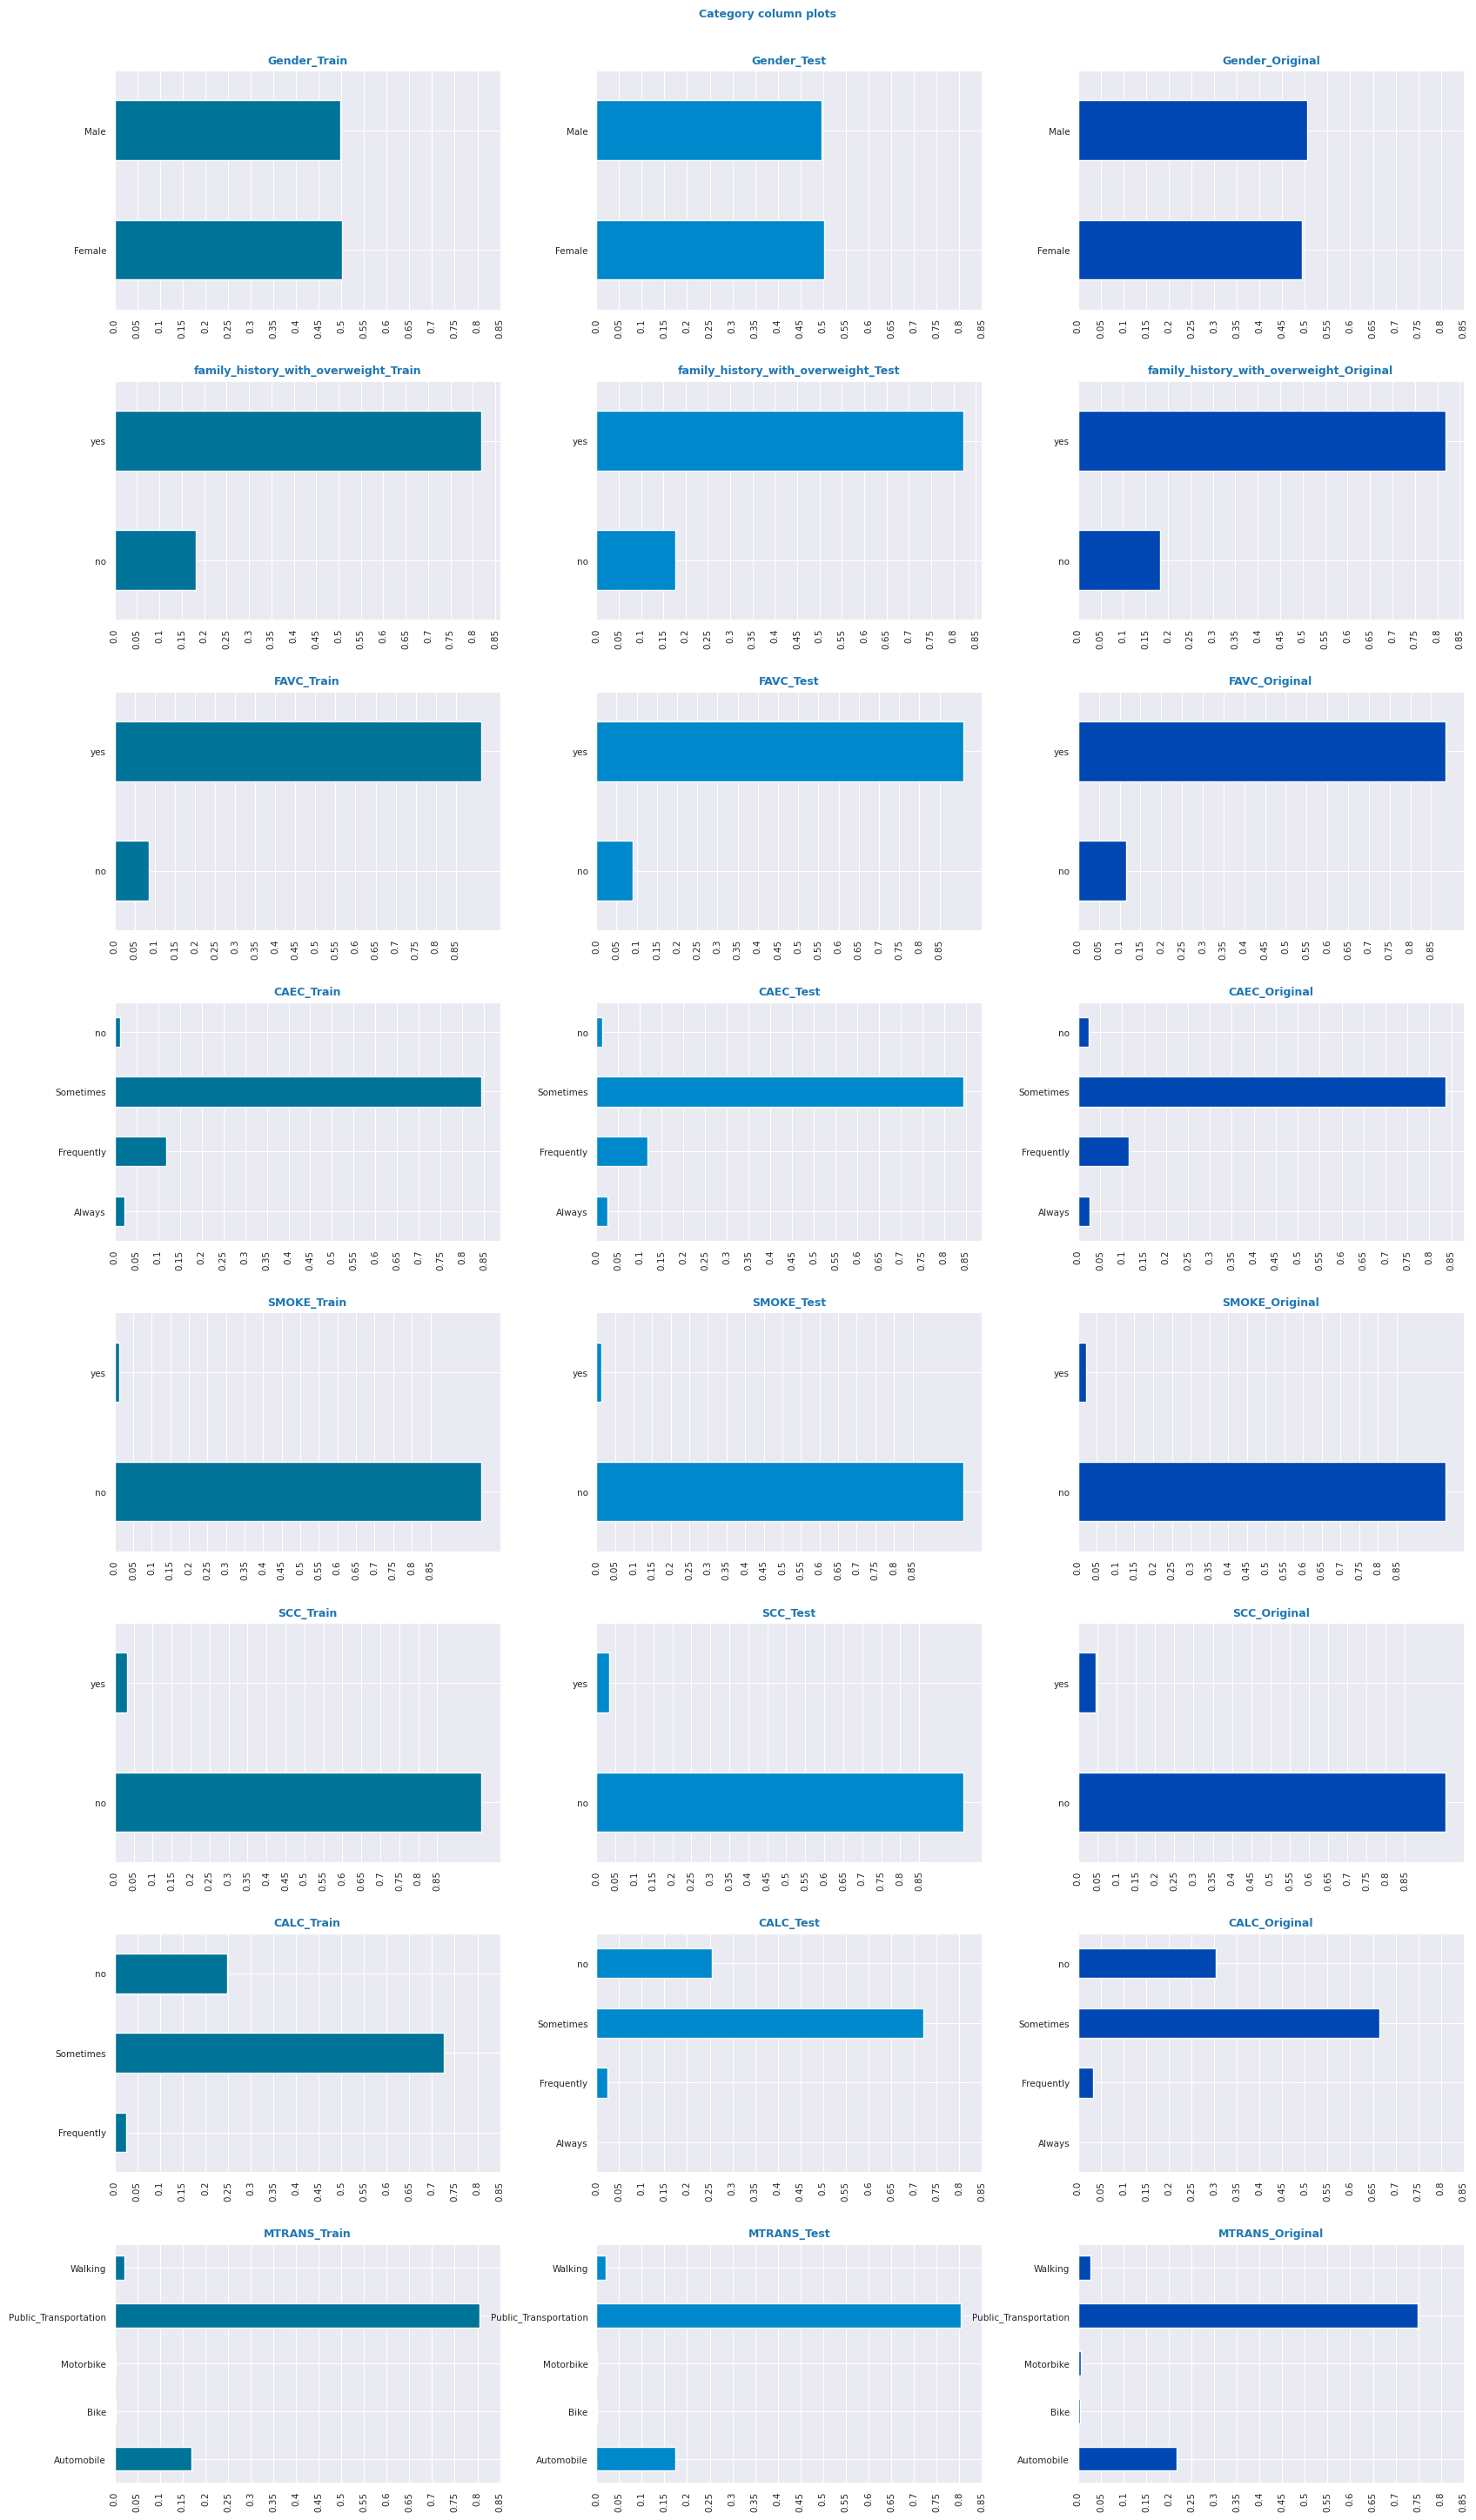


CPU times: user 8.56 s, sys: 82.2 ms, total: 8.64 s
Wall time: 8.64 s


In [14]:
%%time 

if CFG.ftre_plots_req == "Y" and cat_cols != []:
    fig, axes = plt.subplots(len(cat_cols), 3, figsize = (20, len(cat_cols)* 4.5), 
                             gridspec_kw = {'wspace': 0.25, 'hspace': 0.3});

    for i, col in enumerate(cat_cols):
        ax = axes[i, 0];
        a = pp.train[col].value_counts(normalize = True);
        a.sort_index().plot.barh(ax = ax, color = '#007399');
        ax.set_title(f"{col}_Train", **CFG.title_specs);
        ax.set_xticks(np.arange(0.0, 0.9, 0.05), 
                      labels = np.round(np.arange(0.0, 0.9, 0.05),2), 
                      rotation = 90
                     );
        ax.set(xlabel = '', ylabel = '');
        del a;

        ax = axes[i, 1];
        a = pp.test[col].value_counts(normalize = True);
        a.sort_index().plot.barh(ax = ax, color = '#0088cc');
        ax.set_title(f"{col}_Test", **CFG.title_specs);
        ax.set_xticks(np.arange(0.0, 0.9, 0.05), 
                      labels = np.round(np.arange(0.0, 0.9, 0.05),2), 
                      rotation = 90
                     );
        ax.set(xlabel = '', ylabel = '');
        del a;
        
        ax = axes[i, 2];
        a = pp.original[col].value_counts(normalize = True);
        a.sort_index().plot.barh(ax = ax, color = '#0047b3');
        ax.set_title(f"{col}_Original", **CFG.title_specs);
        ax.set_xticks(np.arange(0.0, 0.9, 0.05), 
                      labels = np.round(np.arange(0.0, 0.9, 0.05),2), 
                      rotation = 90
                     );
        ax.set(xlabel = '', ylabel = '');
        del a;       
    
    plt.suptitle(f"Category column plots", **CFG.title_specs, y= 0.90);
    plt.tight_layout();
    plt.show();
    
print();
collect();


<a id="5.7"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > FEATURE INTERACTION AND UNIVARIATE RELATIONS<br><div>
    


In [15]:
%%time 

def MakeCorrPlot(df: pd.DataFrame, data_label:str, figsize = (30, 9)):
    """
    This function develops the correlation plots for the given dataset
    """;
    
    fig, axes = plt.subplots(1,2, figsize = figsize, gridspec_kw = {'hspace': 0.2, 'wspace': 0.1},
                             sharey = True
                            );
    
    for i, method in enumerate(['pearson', 'spearman']):
        corr_ = df.drop(columns = ['id', 'Source'], errors = 'ignore').corr(method = method);
        ax = axes[i];
        sns.heatmap(data = corr_,  
                    annot= True,
                    fmt= '.2f', 
                    cmap = 'Blues',
                    annot_kws= {'fontweight': 'bold','fontsize': 6.75}, 
                    linewidths= 1.5, 
                    linecolor='white', 
                    cbar= False, 
                    mask= np.triu(np.ones_like(corr_)),
                    ax= ax
                   );
        ax.set_title(f"\n{method.capitalize()} correlation- {data_label}\n", **CFG.title_specs);
        
    collect();
    print();

print();
collect();


CPU times: user 180 ms, sys: 0 ns, total: 180 ms
Wall time: 180 ms


<a id="5.12"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > INFERENCES<br> <div>

<div style= "font-family: Cambria; letter-spacing: 0px; color:#000000; font-size:110%; text-align:left;padding:3.0px; background: #f2f2f2" >
1. Features are positively and negatively skewed and are all non-negative. Feature transforms may be useful for non-tree models<br>
2. Outlier treatment could be considered as an option considering outlier presence across all columns in the data<br>
3. Obesity category 2 and 3 are highly influenced by gender- this may entail post-processing perhaps for the private evaluation <br>
</div>

<a id="6"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > DATA TRANSFORMS <br><div> 
    
This section aims at creating secondary features, scaling and if necessary, conjoining the competition training and original data tables<br>


In [16]:
%%time 

# Data transforms:-
class Xformer(TransformerMixin, BaseEstimator):
    """
    This class adds secondary features to the existing data using simple interactions
    """;
    
    def __init__(self): 
        self.sec_ftre_req = CFG.sec_ftre_req;
    
    def fit(self, X, y= None, **params):
        return self;
    
    @staticmethod
    def _reduce_mem(df: pd.DataFrame):
        "This method reduces memory for numeric columns in the dataframe";
        
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', "uint16", "uint32", "uint64"];
        start_mem = df.memory_usage().sum() / 1024**2;
        
        for col in df.columns:
            col_type = df[col].dtypes
            
            if col_type in numerics:
                c_min = df[col].min();
                c_max = df[col].max();

                if "int" in str(col_type):
                    if c_min >= np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min >= np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min >= np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min >= np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    if c_min >= np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)  

        end_mem = df.memory_usage().sum() / 1024**2
    
        PrintColor(f"Start - end memory:- {start_mem:5.2f} - {end_mem:5.2f} Mb");
        return df;
    
    def transform(self, X, y= None, **params):
        """
        This method adds secondary features to the existing data
        It also encodes category columns manually
        Source- https://www.kaggle.com/competitions/playground-series-s4e2/discussion/472417
        """;
        
        df = X.copy().fillna(method = "ffill").fillna(method = "bfill"); 
          
        # Encoding the columns appropriately:-        
        df["Gender"] = np.where(df["Gender"] == "Male", 1,0).astype(np.uint8);
        df["family_history_with_overweight"] = \
        np.where(df["family_history_with_overweight"] == "yes", 1,0).astype(np.uint8);
        df['SMOKE'] = np.where(df["SMOKE"] == "yes", 1,0).astype(np.uint8);
        df['FAVC'] = np.where(df["FAVC"] == "no", 1,0).astype(np.uint8);
        df["CAEC"] = df["CAEC"].map({"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3}).astype(np.uint8);
        df['SCC']  = np.where(df["SCC"] == "no", 1,0).astype(np.uint8);
        df["CALC"] = df["CALC"].map({"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 2}).astype(np.uint8);

               
        df["BMI"]     = df["Weight"] / df["Height"]**2;
        df["BMI_Grp"] = \
        np.select([df["BMI"] < 18.5, df["BMI"] < 25, df["BMI"] < 30, df["BMI"] < 35, df["BMI"] < 40],
                  [0,1,2,3,4], 5
                 ).astype(np.int8);
        
        if self.sec_ftre_req == "Y":   
            df["BMIbyNCP"]  = np.log1p(df["BMI"]) - np.log1p(df["NCP"]);
            df["BMIFAF"]    = (df["BMI"] * df["FAF"])/ 25.0;
            df["FAFmTUE"]   = df["FAF"] - df["TUE"];
            df["FCVCpNCP"]  = df['FCVC'] * df['NCP'];
            df['TechUse']   = np.log1p(df['TUE']) - np.log1p(df['Age']);
             
            
        self.op_cols = df.columns;
        df = self._reduce_mem(df);
        return df;
    
    def get_feature_names_in(self, X, y=None, **params): 
        return self.ip_cols;    
    
    def get_feature_names_out(self, X, y=None, **params): 
        return self.op_cols;
    
collect();
print();


CPU times: user 182 ms, sys: 0 ns, total: 182 ms
Wall time: 181 ms


In [17]:
%%time

PrintColor(f"\n{'='* 20} Data transformation {'='* 20} \n");

ytrain = train[CFG.target];
Xtrain = train.drop(columns = [CFG.target]);
Xtest  = test.copy(deep = True);

PrintColor(f"\n---> Train data\n");
display(Xtrain.head(5).style.format(precision = 2));
PrintColor(f"\n---> Test data\n");
display(Xtest.head(5).style.format(precision = 2));

# Designing the data pipeline:-
myenc = \
ColumnTransformer(transformers = [("OH", OneHotEncoder(use_cat_names = True), CFG.OH_cols)],
                  verbose_feature_names_out  = False,
                  remainder = 'passthrough',
                 );

xform  = Pipeline(steps = [("OH", myenc), ("Xfrm", Xformer())]);  
Xtrain = xform.fit_transform(Xtrain, ytrain);
Xtest  = xform.transform(Xtest);
print();

# Checking the results:-
with np.printoptions(linewidth = 160):
    PrintColor(f"\n---> Train data columns after data pipeline\n");
    pprint(np.array(Xtrain.columns));

    PrintColor(f"\n---> Test data columns after data pipeline\n");
    pprint(np.array(Xtest.columns));
    PrintColor(f"\n---> Train-test shape after pipeline = {Xtrain.shape} {Xtest.shape}");

    PrintColor(f"\n---> Dropping duplicates in the train data");
    _ = pd.concat([Xtrain, ytrain], axis=1).drop_duplicates(subset = Xtrain.columns[0:-1].to_list());
    _.index = range(len(_));
    Xtrain, ytrain = _.drop(columns = [CFG.target]), _[CFG.target];
    del _;
    PrintColor(f"---> Train-test shape after duplicate removal = {Xtrain.shape} {Xtest.shape}");

print();
collect();


==================== Data transformation ==================== 


---> Train data



,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Source
id,,,,,,,,,,,,,,,,,
0,Male,24.44,1.70,81.67,yes,yes,2.00,2.98,Sometimes,no,2.76,no,0.00,0.98,Sometimes,Public_Transportation,Competition
1,Female,18.00,1.56,57.00,yes,yes,2.00,3.00,Frequently,no,2.00,no,1.00,1.00,no,Automobile,Competition
2,Female,18.00,1.71,50.17,yes,yes,1.88,1.41,Sometimes,no,1.91,no,0.87,1.67,no,Public_Transportation,Competition
3,Female,20.95,1.71,131.27,yes,yes,3.00,3.00,Sometimes,no,1.67,no,1.47,0.78,Sometimes,Public_Transportation,Competition
4,Male,31.64,1.91,93.80,yes,yes,2.68,1.97,Sometimes,no,1.98,no,1.97,0.93,Sometimes,Public_Transportation,Competition



---> Test data



,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Source
id,,,,,,,,,,,,,,,,,
20758,Male,26.90,1.85,120.64,yes,yes,2.94,3.00,Sometimes,no,2.83,no,0.86,0.00,Sometimes,Public_Transportation,Competition
20759,Female,21.00,1.60,66.00,yes,yes,2.00,1.00,Sometimes,no,3.00,no,1.00,0.00,Sometimes,Public_Transportation,Competition
20760,Female,26.00,1.64,111.60,yes,yes,3.00,3.00,Sometimes,no,2.62,no,0.00,0.25,Sometimes,Public_Transportation,Competition
20761,Male,20.98,1.55,103.67,yes,yes,2.00,2.98,Sometimes,no,2.79,no,0.09,0.00,Sometimes,Public_Transportation,Competition
20762,Female,26.00,1.63,104.84,yes,yes,3.00,3.00,Sometimes,no,2.65,no,0.00,0.74,Sometimes,Public_Transportation,Competition


Start - end memory:-  3.66 -  1.68 Mb
Start - end memory:-  2.32 -  1.12 Mb


---> Train data columns after data pipeline

array(['MTRANS_Public_Transportation', 'MTRANS_Automobile', 'MTRANS_Walking', 'MTRANS_Motorbike', 'MTRANS_Bike', 'Gender', 'Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'Source', 'BMI', 'BMI_Grp', 'BMIbyNCP',
       'BMIFAF', 'FAFmTUE', 'FCVCpNCP', 'TechUse'], dtype=object)

---> Test data columns after data pipeline

array(['MTRANS_Public_Transportation', 'MTRANS_Automobile', 'MTRANS_Walking', 'MTRANS_Motorbike', 'MTRANS_Bike', 'Gender', 'Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'Source', 'BMI', 'BMI_Grp', 'BMIbyNCP',
       'BMIFAF', 'FAFmTUE', 'FCVCpNCP', 'TechUse'], dtype=object)

---> Train-test shape after pipeline = (22845, 28) (13840, 28)

---> Dropping dupli

In [18]:
%%time 

# Shortlisting the duplicate data between train and test dataframes for post-processing:-
join_cols = Xtrain.columns[0:-1].to_list();

dups_df = \
Xtrain.\
reset_index(names = "id").\
assign(Label = "Train").\
merge(Xtest.reset_index().assign(Label = "Test"),
      how = "inner", on = join_cols, suffixes = ("_train", "_test")).\
drop(columns = join_cols).\
merge(ytrain, how = "inner", left_on = "id_train", right_index = True)\
[['id_train', 'id_test', CFG.target]].\
drop_duplicates(subset = ['id_test']);

del join_cols;

PrintColor(f"\n---> Train-test duplicate data glimpse- shape = {dups_df.shape}");
display(dups_df.head(10).style.format(precision = 3));
dups_df.to_csv(f"Duplicates.csv", index = None);

collect();
print();


---> Train-test duplicate data glimpse- shape = (36, 3)


,id_train,id_test,NObeyesdad
0,88,29195,Obesity_Type_III
1,88,31817,Obesity_Type_III
2,1691,21601,Obesity_Type_III
3,1691,24500,Obesity_Type_III
4,2783,28900,Obesity_Type_III
5,3031,23912,Obesity_Type_III
6,3324,22561,Obesity_Type_III
7,3324,32404,Obesity_Type_III
8,4323,27557,Obesity_Type_III
9,4532,24649,Obesity_Type_III



CPU times: user 240 ms, sys: 2.66 ms, total: 242 ms
Wall time: 247 ms





CPU times: user 3.23 s, sys: 52.4 ms, total: 3.28 s
Wall time: 3.28 s


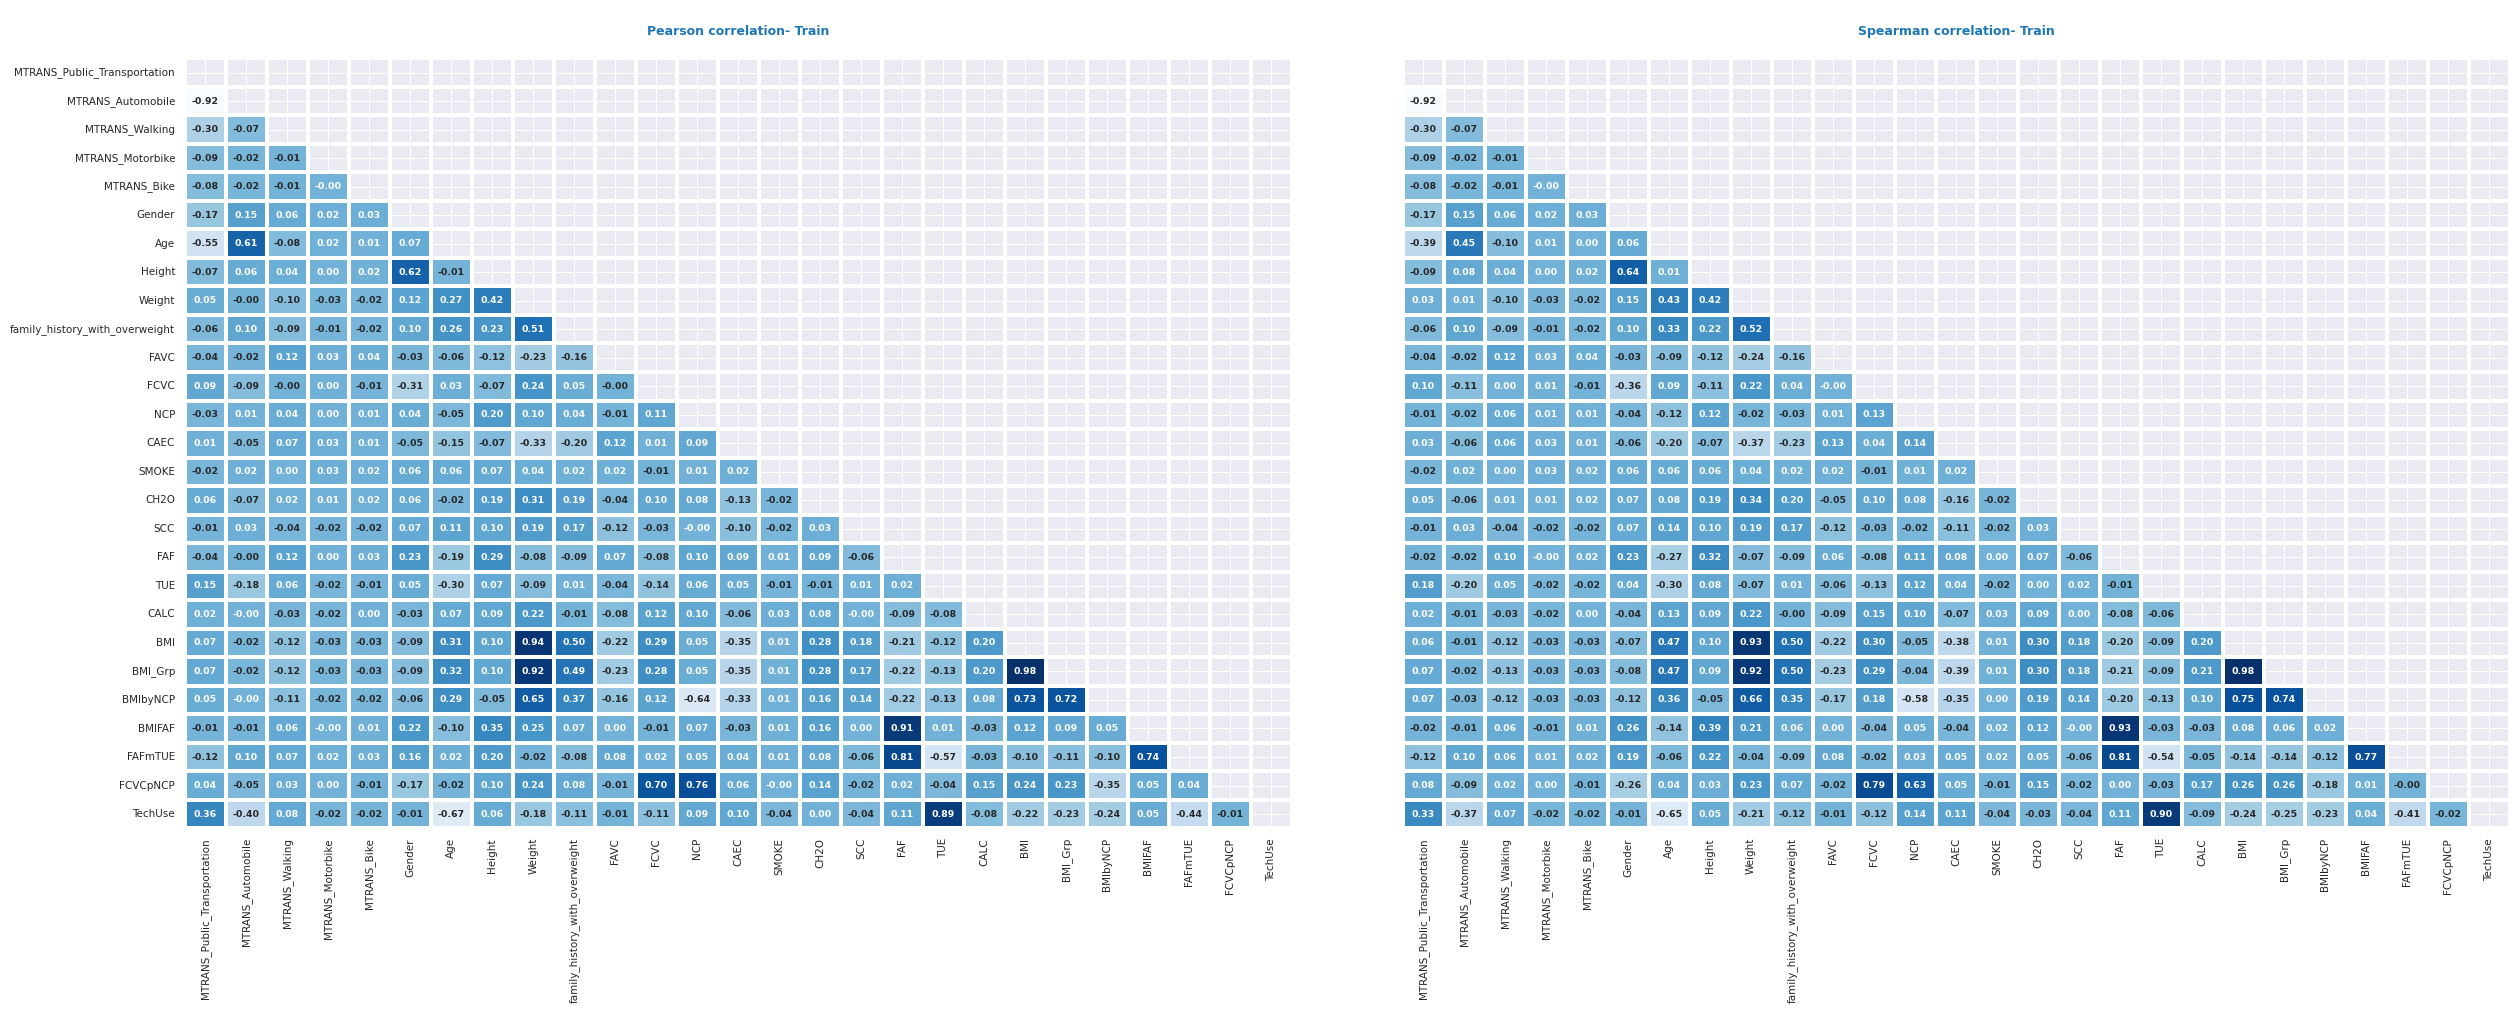

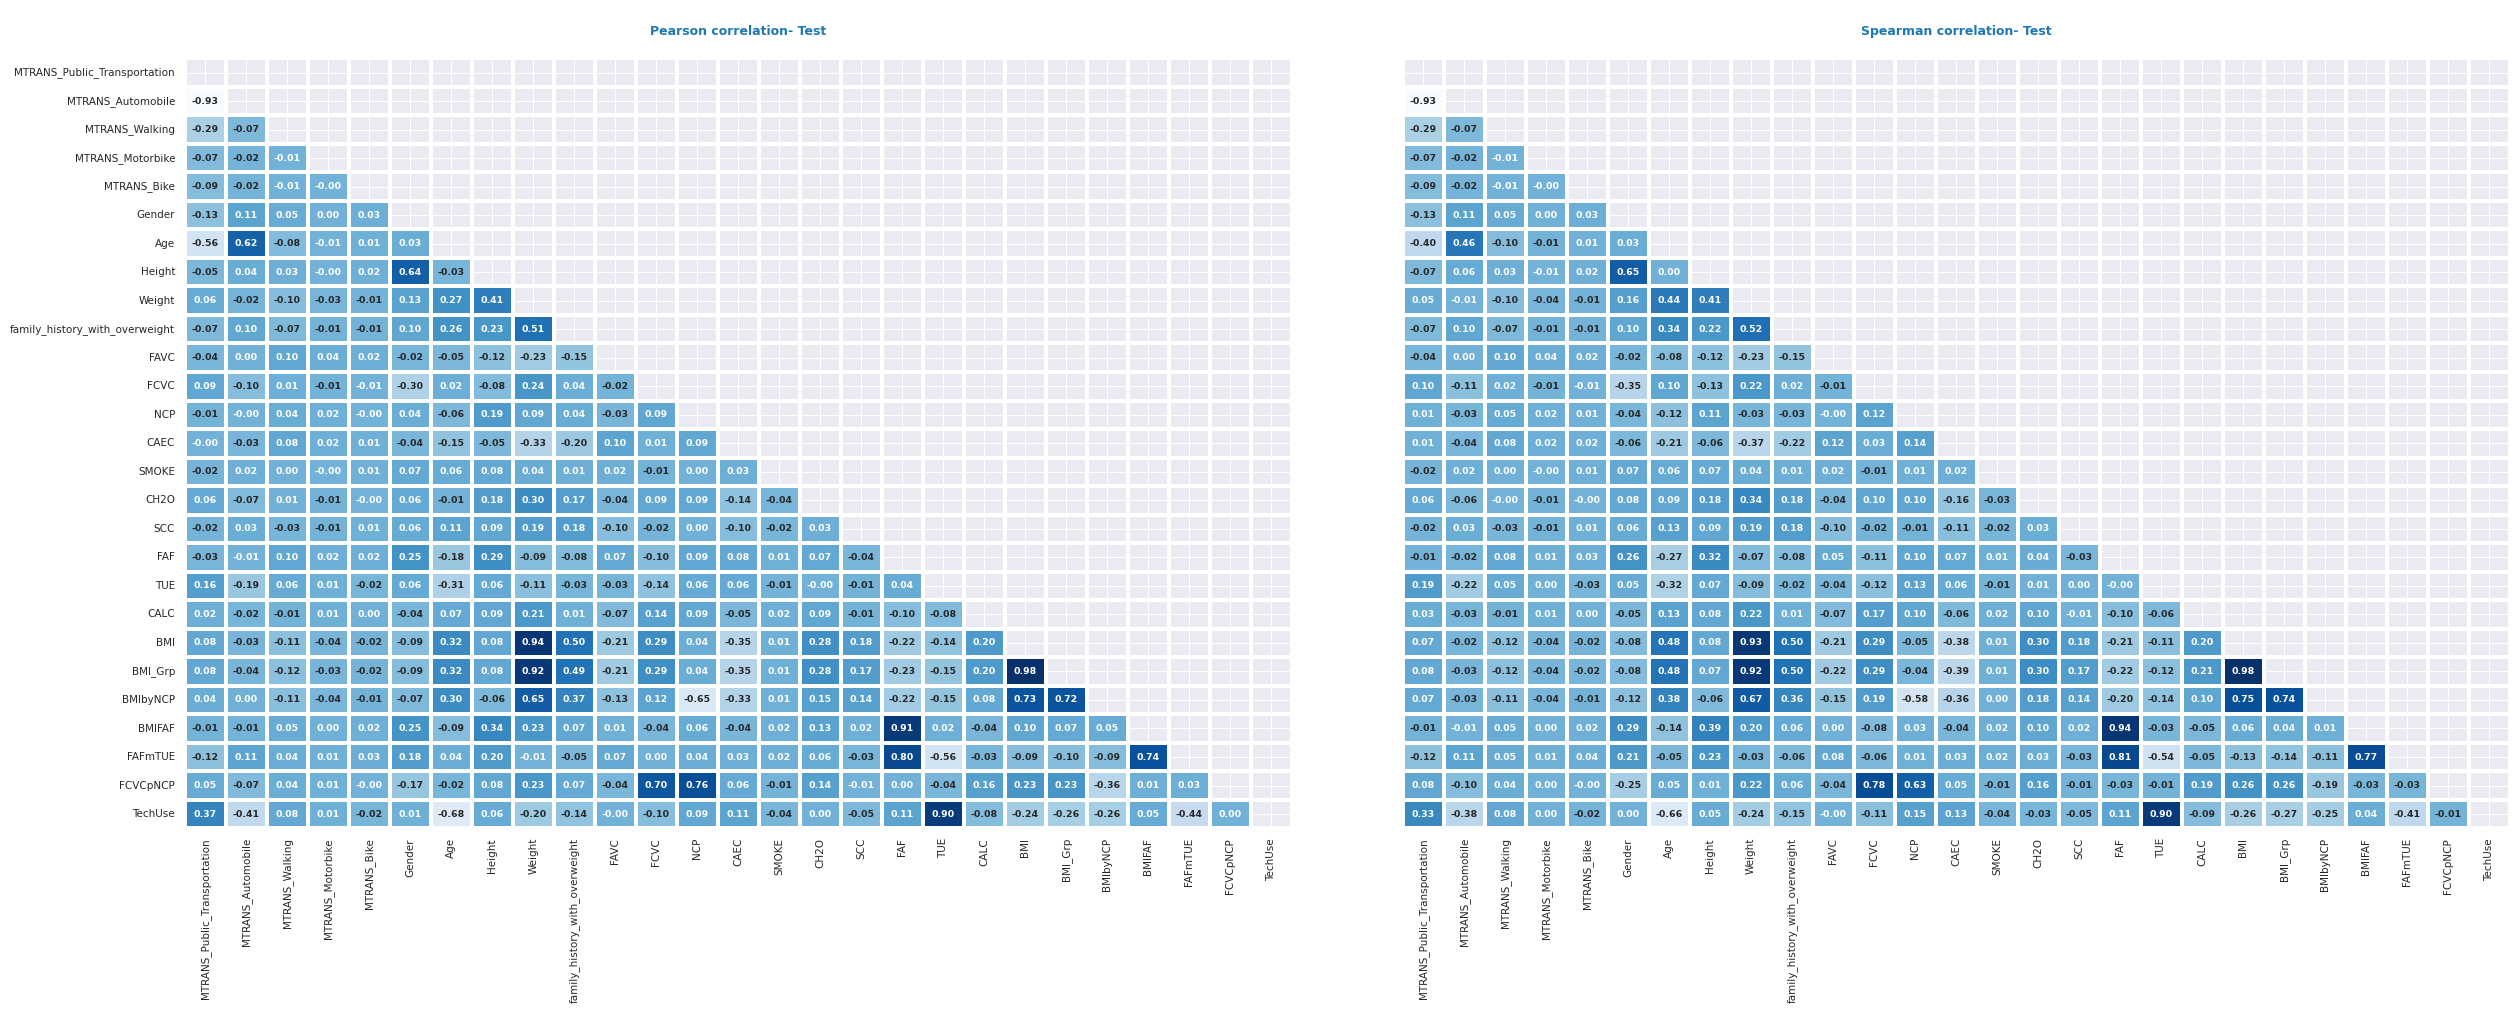

In [19]:
%%time 

# Implementing correlation analysis:-
if CFG.ftre_imp_req == "Y":
    MakeCorrPlot(df = Xtrain, data_label = "Train", figsize = (30,10));
    MakeCorrPlot(df = Xtest,  data_label = "Test",  figsize = (30,10));
    
print();
collect();

<a id="7"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > MODEL TRAINING <br><div> 
   

In [20]:
%%time 

class OptunaWeights:
    """
    This is the Optuna ensemble class-
    Source- https://www.kaggle.com/code/arunklenin/ps3e26-cirrhosis-survial-prediction-multiclass
    """;
    
    def __init__(self):
        self.study        = None;
        self.weights      = None;
        self.random_state = CFG.state;
        self.n_trials     = CFG.ntrials;
        self.direction    = CFG.metric_obj;
        
    def ScoreMetric(self, ytrue, ypred):
        """
        This is the metric function for the ensemble
        """;
        return accuracy_score(ytrue, ypred);

    def _objective(self, trial, y_true, y_preds):
        """
        This method defines the objective function for the ensemble
        """;
        
        weights = [trial.suggest_float(f"weight{n}", 0, 1) for n in range(len(y_preds))]

        # Calculating the weighted prediction:-
        weighted_pred  = np.average(np.array(y_preds), axis=0, weights = weights);
        weighted_pred  = weighted_pred / weighted_pred.sum(axis=1, keepdims = True);
        score          = self.ScoreMetric(y_true, np.argmax(weighted_pred, axis=1));
        return score;

    def fit(self, y_true, y_preds):
        "This method fits the Optuna objective on the fold level data";
        
        optuna.logging.set_verbosity = optuna.logging.ERROR;
        self.study = \
        optuna.create_study(sampler    = TPESampler(seed = self.random_state), 
                            pruner     = HyperbandPruner(),
                            study_name = "OptunaWeights", 
                            direction  = self.direction,
                           );
        
        obj = partial(self._objective, y_true = y_true, y_preds = y_preds);
        self.study.optimize(obj, n_trials = self.n_trials);
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))];
        clear_output();

    def predict(self, y_preds):
        "This method predicts using the fitted Optuna objective";
        
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds), axis=0, weights = self.weights);
        return weighted_pred;

    def fit_predict(self, y_true, y_preds):
        """
        This method fits the Optuna objective on the fold data, then predicts the test set
        """;
        self.fit(y_true, y_preds);
        return self.predict(y_preds);
    
    def weights(self):
        return self.weights;
    
print();
collect();



CPU times: user 302 ms, sys: 153 µs, total: 303 ms
Wall time: 300 ms


In [21]:
%%time 

class MdlDeveloper(CFG):
    """
    This class implements the training pipeline elements-
    1. Initializes the Model predictions
    2. Trains and infers models
    3. Returns the OOF and model test set predictions
    """;
    
    def __init__(self, Xtrain, ytrain, Xtest, sel_cols, cat_cols, **kwarg):
        """
        In this method, we initialize the below-
        1. Train-test data, selected columns
        2. Metric, custom scorer, model and cv object
        3. Output tables for score and predictions
        
        Note:-
        OOF_Preds contains the ensemble OOF predictions per fold averaged across all folds
        """;
        
        self.Xtrain      = Xtrain;
        self.Ytrain      = ytrain;
        self.Xtest       = Xtest;
        self.sel_cols    = sel_cols;
        self.cat_cols    = cat_cols;

        self.tgt_cat     = CFG.tgt_mapper;
        self.tgt_cat_inv = {i:j for j, i in CFG.tgt_mapper.items()};
        self.nclass      = len(CFG.tgt_mapper.keys());
        self.ytrain      = self.Ytrain.map(self.tgt_cat).astype(np.uint8);
        
        self._DefineModels();
        self.cv          = self.all_cv[CFG.mdlcv_mthd];
        self.methods     = list(self.Mdl_Master.keys());
        self.OOF_Preds   = pd.DataFrame(columns = [f"Status_{k}" for k in self.tgt_cat.keys()]);
        self.Mdl_Preds   = pd.DataFrame(columns = [f"Status_{k}" for k in self.tgt_cat.keys()]);
        self.Scores      = pd.DataFrame(columns = self.methods, index = range(CFG.n_splits * CFG.n_repeats));
        self.TrainScores = pd.DataFrame(columns = self.methods, index = range(CFG.n_splits * CFG.n_repeats));
        
        self.mdlscorer   = make_scorer(self.ScoreMetric, 
                                       greater_is_better = False if self.metric_obj == "minimize" else True,
                                       needs_proba       = True,
                                       needs_threshold   = False,
                                      );  
        self.y_grp = self.ytrain;

        PrintColor(f"\n---> Selected model options-");
        pprint(self.methods, depth = 1, width = 100, indent = 5);
              
    def _DefineModels(self):
        """
        This method initiliazes models for the analysis
        It also initializes the CV methods and class-weights that could be tuned going ahead.
        """;
        
        # Commonly used CV strategies for later usage:-
        self.all_cv = \
        {'KF'  : KFold(n_splits= CFG.n_splits, shuffle = True, random_state= CFG.state),
         'RKF' : RKF(n_splits= CFG.n_splits, n_repeats = CFG.n_repeats, random_state= CFG.state),
         'RSKF': RSKF(n_splits= CFG.n_splits, n_repeats = CFG.n_repeats, random_state= CFG.state),
         'SKF' : SKF(n_splits= CFG.n_splits, shuffle = True, random_state= CFG.state)
        };
               
        self.Mdl_Master = \
        {                      
         'XGB1C': XGBC(**{'tree_method'           : "gpu_hist" if CFG.gpu_switch == "ON" else "hist",
                          'objective'             : 'multi:softprob',
                          'eval_metric'           : "mlogloss",
                          'num_class'             : self.nclass,
                          'random_state'          : CFG.state,
                          'colsample_bytree'      : 0.68,
                          'learning_rate'         : 0.032,
                          'gamma'                 : 0.018,
                          'max_depth'             : 4,
                          'n_estimators'          : 1100,                         
                          'reg_alpha'             : 0.53,
                          'reg_lambda'            : 0.70,
                          'min_child_weight'      : 9,
                          'early_stopping_rounds' : CFG.nbrnd_erly_stp,
                          'verbosity'             : 0,
                          'multi_strategy'        : "multi_output_tree",
                         }
                      ),
            
         'XGB2C': XGBC(**{'tree_method'           : "gpu_hist" if CFG.gpu_switch == "ON" else "hist",
                          'objective'             : 'multi:softprob',
                          'eval_metric'           : "mlogloss",
                          'num_class'             : self.nclass,
                          'random_state'          : CFG.state,
                          'colsample_bytree'      : 0.40,
                          'learning_rate'         : 0.04,
                          'max_depth'             : 5,
                          'n_estimators'          : 1100,                         
                          'reg_alpha'             : 0.8,
                          'reg_lambda'            : 0.65,
                          'min_child_weight'      : 11,
                          'early_stopping_rounds' : CFG.nbrnd_erly_stp,
                          'verbosity'             : 0,
                         }
                      ),

         'XGB3C': XGBC(**{'tree_method'           : "gpu_hist" if CFG.gpu_switch == "ON" else "hist",
                          'objective'             : 'multi:softprob',
                          'eval_metric'           : "mlogloss",
                          'num_class'             : self.nclass,
                          'random_state'          : CFG.state,
                          'colsample_bytree'      : 0.5,
                          'learning_rate'         : 0.03,
                          'max_depth'             : 7,
                          'n_estimators'          : 1100,                         
                          'reg_alpha'             : 0.2,
                          'reg_lambda'            : 0.6,
                          'min_child_weight'      : 11,
                          'early_stopping_rounds' : CFG.nbrnd_erly_stp,
                          'verbosity'             : 0,
                         }
                      ),
            
         'XGB4C': XGBC(**{'tree_method'           : "gpu_hist" if CFG.gpu_switch == "ON" else "hist",
                          'objective'             : 'multi:softprob',
                          'eval_metric'           : "mlogloss",
                          'num_class'             : self.nclass,
                          'random_state'          : CFG.state,
                          'colsample_bytree'      : 0.65,
                          'learning_rate'         : 0.0375,
                          'max_depth'             : 6,
                          'n_estimators'          : 2000,                         
                          'reg_alpha'             : 0.61,
                          'reg_lambda'            : 1.05,
                          'min_child_weight'      : 12,
                          'early_stopping_rounds' : CFG.nbrnd_erly_stp,
                          'verbosity'             : 0,
                         }
                      ),
              
         'LGBM1C':LGBMC(**{'device'              : "gpu" if CFG.gpu_switch == "ON" else "cpu",
                           'objective'           : 'multiclass',
                           'num_class'           : self.nclass,
                           'boosting_type'       : 'gbdt',
                           'random_state'        : CFG.state,
                           'colsample_bytree'    : 0.7,
                           'subsample'           : 0.75,
                           'learning_rate'       : 0.035,
                           'max_depth'           : 6,
                           'n_estimators'        : 3000,
                           'num_leaves'          : 50,
                           'reg_alpha'           : 0.14,
                           'reg_lambda'          : 0.85,
                           'verbosity'           : -1,
                           'categorical_feature' : [f"name: {col}" for col in self.cat_cols],
                          }
                       ),
            
         'LGBM2C':LGBMC(**{'device'              : "gpu" if CFG.gpu_switch == "ON" else "cpu",
                           'objective'           : 'multiclass',
                           'num_class'           : self.nclass,
                           'boosting_type'       : 'gbdt',
                           'data_sample_strategy': "goss",
                           'random_state'        : CFG.state,
                           'colsample_bytree'    : 0.20,
                           'subsample'           : 0.25,
                           'learning_rate'       : 0.04,
                           'max_depth'           : 8,
                           'n_estimators'        : 3000,
                           'num_leaves'          : 60, 
                           'reg_alpha'           : 0.15,
                           'reg_lambda'          : 0.90,
                           'verbosity'           : -1,
                           'categorical_feature' : [f"name: {col}" for col in self.cat_cols],
                          }
                       ),
            
         'LGBM3C':LGBMC(**{'device'              : "gpu" if CFG.gpu_switch == "ON" else "cpu",
                           'objective'           : 'multiclass',
                           'num_class'           : self.nclass,
                           'boosting_type'       : 'gbdt',
                           'random_state'        : CFG.state,
                           'colsample_bytree'    : 0.45,
                           'subsample'           : 0.45,
                           'learning_rate'       : 0.042,
                           'max_depth'           : 6,
                           'n_estimators'        : 3000,
                           'num_leaves'          : 90, 
                           'reg_alpha'           : 0.05,
                           'reg_lambda'          : 0.95,
                           'verbosity'           : -1,
                           'categorical_feature' : [f"name: {col}" for col in self.cat_cols],
                          }
                       ), 
            
         'LGBM4C':LGBMC(**{'device'              : "gpu" if CFG.gpu_switch == "ON" else "cpu",
                           'objective'           : 'multiclass',
                           'num_class'           : self.nclass,
                           'boosting_type'       : 'gbdt',
                           'random_state'        : CFG.state,
                           'colsample_bytree'    : 0.55,
                           'subsample'           : 0.55,
                           'learning_rate'       : 0.045,
                           'max_depth'           : 6,
                           'n_estimators'        : 3000,
                           'num_leaves'          : 100, 
                           'reg_alpha'           : 0.08,
                           'reg_lambda'          : 0.995,
                           'verbosity'           : -1,
                           'categorical_feature' : [f"name: {col}" for col in self.cat_cols],
                          }
                       ),
            
          "CB1C" : CBC(**{'task_type'           : "GPU" if CFG.gpu_switch == "ON" else "CPU",
                          'objective'           : 'MultiClass',
                          'eval_metric'         : "Accuracy",
                          'bagging_temperature' : 0.1,
                          'colsample_bylevel'   : 0.88,
                          'iterations'          : 1000,
                          'learning_rate'       : 0.05,
                          'od_wait'             : 12,
                          'max_depth'           : 7,
                          'l2_leaf_reg'         : 1.75,
                          'min_data_in_leaf'    : 15,
                          'random_strength'     : 0.1, 
                          'max_bin'             : 100,
                          'verbose'             : 0,
                          'use_best_model'      : True,
                         }
                      ),
            
          "CB2C" : CBC(**{'task_type'           : "GPU" if CFG.gpu_switch == "ON" else "CPU",
                          'objective'           : 'MultiClass',
                          'eval_metric'         : "Accuracy",
                          'bagging_temperature' : 0.4,
                          'colsample_bylevel'   : 0.65,
                          'iterations'          : 1000,
                          'learning_rate'       : 0.038,
                          'od_wait'             : 12,
                          'max_depth'           : 5,
                          'l2_leaf_reg'         : 0.70,
                          'min_data_in_leaf'    : 9,
                          'random_strength'     : 0.175, 
                          'max_bin'             : 100,
                          'verbose'             : 0,
                          'use_best_model'      : True,
                          "grow_policy"         : "Lossguide",
                         }
                      ),            
            
        };
        return self;
    
    def ScoreMetric(self, ytrue, ypred):
        """
        This is the metric function for the competition
        """;
        return accuracy_score(ytrue, ypred);
    
    def PostProcessPred(self, ypred):
        """
        This is an optional post-processing method
        """;
        return ypred;
    
    def TrainMdl(self, test_preds_req: str = "Y"):
        """
        This method trains and infers from the model suite and returns the predictions and scores
        It optionally predicts the test set too, if desired by the user
        """;

        # Initializing I-O:- 
        X,y, Xt    = self.Xtrain[self.sel_cols], self.ytrain.copy(deep = True), self.Xtest[self.sel_cols];
        cols_drop  = ['Source', "id"];
        ens        = OptunaWeights();
        
        # Making CV folds:-        
        for fold_nb, (train_idx, dev_idx) in tqdm(enumerate(self.cv.split(X, self.y_grp))):
            Xtr  = X.iloc[train_idx].drop(columns = cols_drop, errors = 'ignore');  
            Xdev = X.iloc[dev_idx].loc[X.Source == "Competition"].drop(columns = cols_drop, errors = 'ignore'); 
            
            ytr  = y.loc[y.index.isin(Xtr.index)];
            ydev = y.loc[y.index.isin(Xdev.index)];
                   
            # Initializing the OOF and test set predictions:-            
            oof_preds, mdl_preds = [], [];
            
            PrintColor(f"\n{'=' * 5} FOLD {fold_nb + 1} {'=' * 5}\n");
            # Initializing models across methods:-
            for method in tqdm(self.methods):
                model = Pipeline(steps = [("M", self.Mdl_Master.get(method))]); 

                # Fitting the model:-          
                if "CB" in method:    
                    model.fit(Xtr, ytr, 
                              M__eval_set = [(Xdev, ydev)], 
                              M__verbose = 0,
                              M__early_stopping_rounds = CFG.nbrnd_erly_stp,
                              M__cat_features = self.cat_cols
                             ); 

                elif "LGBM" in method:
                    model.fit(Xtr, ytr, 
                              M__eval_set = [(Xdev, ydev)], 
                              M__callbacks = [log_evaluation(0), 
                                              early_stopping(stopping_rounds = CFG.nbrnd_erly_stp, 
                                                             verbose = False,),
                                             ],
                             ); 

                elif "XGB" in method:
                     model.fit(Xtr, ytr, 
                               M__eval_set = [(Xdev, ydev)], 
                               M__verbose  = 0,
                              );            

                else: 
                    model.fit(Xtr, ytr);

                # Collecting predictions and scores and post-processing OOF based on model method:-
                dev_preds   = model.predict_proba(Xdev);
                train_preds = model.predict_proba(Xtr);
                oof_preds.append(dev_preds);
            
                if test_preds_req == "Y": 
                    test_preds = model.predict_proba(Xt.drop(columns = cols_drop, errors = "ignore"));
                    mdl_preds.append(test_preds);
                    del test_preds;
            
                tr_score = self.ScoreMetric(ytr.values.flatten(),np.argmax(train_preds, axis=1));
                score    = self.ScoreMetric(ydev.values.flatten(),np.argmax(dev_preds, axis=1));
                
                num_space = 3 if fold_nb <= 9 else 2;
                PrintColor(f"OOF = {score:.5f} | Train = {tr_score:.5f} | {method}",
                           color = Fore.CYAN
                          );
                del num_space;
            
                # Integrating the predictions and scores:-               
                self.Scores.at[fold_nb, method]      = np.round(score, decimals= 6);
                self.TrainScores.at[fold_nb, method] = np.round(tr_score, decimals= 6);
                del dev_preds;
                
            # Ensembling the predictions:-
            ens.fit(ydev, oof_preds);
            self.OOF_Preds = \
            pd.concat([self.OOF_Preds,
                       pd.DataFrame(ens.predict(oof_preds), index = Xdev.index, columns = self.OOF_Preds.columns)],
                      axis = 0, ignore_index = False
                     );
            
            if test_preds_req == "Y": 
                self.Mdl_Preds = \
                pd.concat([self.Mdl_Preds,
                           pd.DataFrame(ens.predict(mdl_preds), index = self.Xtest.index, columns = self.Mdl_Preds.columns)],
                          axis = 0, ignore_index = False
                         );
                
        # Averaging the predictions after all folds:-       
        self.OOF_Preds = self.OOF_Preds.groupby(level = 0).mean();
        if test_preds_req == "Y": 
            self.Mdl_Preds = self.Mdl_Preds.groupby(level = 0).mean();
            
        return self.OOF_Preds, self.Mdl_Preds, self.Scores, self.TrainScores;
    
    def DisplayAdjTbl(self, *args):
        """
        This function displays pandas tables in an adjacent manner, sourced from the below link-
        https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
        """;

        html_str = '';
        for df in args:
            html_str += df.to_html();
        display_html(html_str.replace('table','table style="display:inline"'),raw=True);
         
    def DisplayScores(self):
        "This method displays the scores and their means";
        
        args = \
        [self.Scores.style.format(precision = 5).\
         background_gradient(cmap = "Pastel2", subset = self.methods).\
         set_caption(f"\nOOF scores across methods and folds\n"),
         
         self.TrainScores.style.format(precision = 5).\
         background_gradient(cmap = "Pastel2", subset = self.methods).\
         set_caption(f"\nTrain scores across methods and folds\n")
        ];
        
        PrintColor(f"\n---> OOF score across all methods and folds\n",color = Fore.LIGHTMAGENTA_EX);
        self.DisplayAdjTbl(*args);
        
        args = \
        [self.Scores.mean().to_frame().transpose().style.format(precision = 5).\
         background_gradient(cmap = "icefire", subset = self.methods, axis=1).\
         set_caption(f"\nOOF scores across methods and folds\n"),
         
         self.TrainScores.mean().to_frame().transpose().style.format(precision = 5).\
         background_gradient(cmap = "icefire", subset = self.methods, axis=1).\
         set_caption(f"\nTrain scores across methods and folds\n")
        ]; 
        
        PrintColor(f"\n---> Mean score across all methods and folds\n",color = Fore.LIGHTMAGENTA_EX);
        self.DisplayAdjTbl(*args);
        
        PrintColor(f"\n---> Mean score across all methods and folds = {np.mean(np.ravel(Scores)):.5f}\n",
                   color = Fore.MAGENTA
                  );
        collect();
        
    def MakePseudoLbl(self, cutoff: float, **kwarg):
        """
        This method makes pseudo-labels using confident test set predictions to add to the training data
        """;
        
        # Locating confident test-set predictions:-        
        df         = self.Mdl_Preds.loc[np.amax(self.Mdl_Preds, axis=1) >= cutoff];
        df.columns = list(self.tgt_cat.keys());
        PrintColor(f"---> Pseudo Label additions from test set = {df.shape[0]:,.0f}", color = Fore.RED);
        
        #  Integrating new Xtrain and ytrain based on pseudo-labels:-       
        new_ytrain       = pd.concat([self.Ytrain, df.idxmax(axis=1)], 
                                     axis=0, ignore_index = True
                                    );
        new_ytrain.index = range(len(new_ytrain));
        new_Xtrain       = pd.concat([self.Xtrain, self.Xtest.loc[df.index]], axis=0, ignore_index = True);
        new_Xtrain.index = range(len(new_Xtrain));
        
        #  Verifying the additions:-
        PrintColor(f"---> Revised train set shapes after pseudo labels = {new_Xtrain.shape} {new_ytrain.shape}");
        return new_Xtrain, new_ytrain;
              
print();
collect();


CPU times: user 178 ms, sys: 0 ns, total: 178 ms
Wall time: 178 ms


In [22]:
%%time

if CFG.ML == "Y":
    sel_cols = Xtrain.columns;
    PrintColor(f"\n---> Selected model columns");
    with np.printoptions(linewidth = 150):
        pprint(np.array(sel_cols));
        
    PrintColor(f"\n---> Selected categorical columns");
    cat_ftre = [];
    for c in sel_cols:
        for col in cat_cols:
            if c.startswith(col):
                cat_ftre.append(c);

    with np.printoptions(linewidth = 150):
        pprint(np.array(cat_ftre));

print();
collect();


---> Selected model columns
array(['MTRANS_Public_Transportation', 'MTRANS_Automobile', 'MTRANS_Walking', 'MTRANS_Motorbike', 'MTRANS_Bike', 'Gender', 'Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'Source', 'BMI', 'BMI_Grp',
       'BMIbyNCP', 'BMIFAF', 'FAFmTUE', 'FCVCpNCP', 'TechUse'], dtype=object)

---> Selected categorical columns
array(['MTRANS_Public_Transportation', 'MTRANS_Automobile', 'MTRANS_Walking', 'MTRANS_Motorbike', 'MTRANS_Bike', 'Gender',
       'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC'], dtype='<U30')

CPU times: user 177 ms, sys: 0 ns, total: 177 ms
Wall time: 176 ms


In [23]:
%%time 

if CFG.ML == "Y":
    # Training the models with a CV analysis:-  
    md = MdlDeveloper(Xtrain, ytrain, Xtest, sel_cols = sel_cols, cat_cols = cat_ftre);
    OOF_Preds, Mdl_Preds, Scores, TrainScores = \
    md.TrainMdl(test_preds_req = "Y");
    
    PrintColor(f"\n{'=' * 20} ML MODELS TRAINING AND CV {'=' * 20}\n", color = Fore.MAGENTA);
    md.DisplayScores();
    collect();
    
print();
collect();



==================== ML MODELS TRAINING AND CV ====================


---> OOF score across all methods and folds



,XGB1C,XGB2C,XGB3C,XGB4C,LGBM1C,LGBM2C,LGBM3C,LGBM4C,CB1C,CB2C
0,0.91516,0.91087,0.91230,0.91087,0.90801,0.91373,0.90944,0.91087,0.91087,0.90515
1,0.90029,0.90313,0.90313,0.90266,0.90218,0.90076,0.90551,0.90218,0.90076,0.90029
2,0.91229,0.91084,0.90795,0.90892,0.90747,0.90265,0.91084,0.90988,0.91181,0.90747
3,0.89682,0.89682,0.89537,0.89682,0.89875,0.89730,0.89344,0.89489,0.89585,0.89489
4,0.91214,0.90971,0.91068,0.91214,0.91068,0.90971,0.91165,0.91165,0.90340,0.90631
5,0.90873,0.90922,0.90726,0.90775,0.90628,0.90236,0.90824,0.90677,0.90088,0.89941
6,0.89783,0.90217,0.89976,0.89880,0.89880,0.89687,0.89880,0.89831,0.88867,0.89060
7,0.90446,0.90737,0.90834,0.90446,0.90543,0.90737,0.90592,0.90834,0.90834,0.90592
8,0.91048,0.91240,0.91240,0.91431,0.91144,0.91671,0.91192,0.91240,0.90378,0.91096
9,0.91553,0.91408,0.91602,0.91699,0.91553,0.91553,0.91699,0.91359,0.91262,0.90631



---> Mean score across all methods and folds



,XGB1C,XGB2C,XGB3C,XGB4C,LGBM1C,LGBM2C,LGBM3C,LGBM4C,CB1C,CB2C
0,0.90737,0.90766,0.90732,0.90737,0.90646,0.90630,0.90727,0.90689,0.90370,0.90273
,XGB1C,XGB2C,XGB3C,XGB4C,LGBM1C,LGBM2C,LGBM3C,LGBM4C,CB1C,CB2C
0,0.93332,0.94531,0.95108,0.94755,0.95598,0.96796,0.95641,0.95562,0.93029,0.92322



---> Mean score across all methods and folds = 0.90631


CPU times: user 1h 54min 13s, sys: 1min 42s, total: 1h 55min 56s
Wall time: 57min 27s


In [24]:
%%time 

if CFG.ML == "Y" and CFG.pseudo_lbl_req == "Y":
    Xtrain, ytrain = md.MakePseudoLbl(cutoff = CFG.pseudolbl_up);
    
    # Re-initializing the developer class with the new training set:-  
    md = MdlDeveloper(Xtrain, ytrain, Xtest, sel_cols = sel_cols, cat_cols = cat_ftre);
    OOF_Preds, Mdl_Preds, Scores, TrainScores = md.TrainMdl(test_preds_req = "Y");
    
    PrintColor(f"\n{'=' * 20} ML MODELS TRAINING AND CV AFTER PSEUDO-LABELS {'=' * 20}\n", 
               color = Fore.MAGENTA
              );
    md.DisplayScores();
    collect();    
    
else:
    PrintColor(f"---> Pseudo Labels are not needed", Fore.RED);

print();
collect();

---> Pseudo Labels are not needed

CPU times: user 181 ms, sys: 0 ns, total: 181 ms
Wall time: 181 ms


In [25]:
%%time 

# Saving the datasets:-
if CFG.ML == "Y":
    Mdl_Preds.index.name = "id";
    sub_fl = pp.sub_fl.copy();
    sub_fl[CFG.target] = Mdl_Preds.idxmax(axis=1).apply(lambda x: x.replace("Status_", "")).values;
       
    OOF_Preds.to_csv(f"OOF_Preds_V{CFG.version_nb}.csv");
    Mdl_Preds.to_csv(f"Mdl_Preds_V{CFG.version_nb}.csv");
    
    PrintColor(f"\nFinal submission file before blending\n");
    display(sub_fl.head(10).style.format(precision = 3));
    sub_fl.to_csv(f"SubmissionNoBlend.csv", index = None);
    
    # Blending with public work and generating mode based hard voting:-
    subs = pd.read_csv(CFG.public_subs_path, index_col = "id");

    # Encoding the columns with the configured encoding scheme:-
    subs["mysub"] = sub_fl[CFG.target].values;

    for c in subs.columns:
        subs[c] = subs[c].map(CFG.tgt_mapper).astype(np.int8);

    subs.\
    mode(axis=1)[0].\
    astype(np.int8).map(md.tgt_cat_inv).\
    to_frame().reset_index().\
    rename(columns = {0: CFG.target}).\
    to_csv(f"Submission_V{CFG.version_nb}.csv", index = None);
    
collect();
print(); 


Final submission file before blending



,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
5,20763,Insufficient_Weight
6,20764,Insufficient_Weight
7,20765,Normal_Weight
8,20766,Overweight_Level_II
9,20767,Normal_Weight



CPU times: user 5.88 s, sys: 56.9 ms, total: 5.94 s
Wall time: 5.96 s


<a id="8"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0052cc; border-bottom: 8px solid #cc9966" > NEXT STEPS<br> <div> 

<div style= "font-family: Cambria; letter-spacing: 0px; color:#000000; font-size:110%; text-align:left;padding:3.0px; background: #f2f2f2" >
1. We will perform a detailed EDA and elicit feature interactions and other relevant insights<br>
2. Model tuning<br>
3. Including other models in the ensemble <br>
4. Better ensemble strategy <br>
5. Any other discussion/ public work based insights <br>
</div>